In [ ]:
import tensorflow as tf
from tensorflow import keras
import time
import numpy as np

latent_dim = 2
train_size = 60000
batch_size = 32
test_size = 10000
epochs = 1
num_examples_to_generate = 16
optimizer = tf.keras.optimizers.Adam(1e-4)
DATASET = "mnist"

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

class CVAE(tf.keras.Model):
  """Fully dense variational autoencoder."""

  def __init__(self, latent_dim, enc_dim=[256, 256, 256], dec_dim=[256, 256, 256]):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    enc_arch = [tf.keras.layers.InputLayer(input_shape=(28, 28, 1))]
    for dim in enc_dim:
      enc_arch.append(tf.keras.layers.Dense(dim, activation="relu"))
    enc_arch.append(tf.keras.layers.Flatten())
    enc_arch.append(tf.keras.layers.Dense(latent_dim + latent_dim))

    dec_arch = [tf.keras.layers.InputLayer(input_shape=(latent_dim,))]
    for dim in dec_dim:
      dec_arch.append(tf.keras.layers.Dense(dim, activation="relu"))
    dec_arch.append(tf.keras.layers.Dense(784))
    dec_arch.append(tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)))

    self.encoder = tf.keras.Sequential(enc_arch)

    self.decoder = tf.keras.Sequential(dec_arch)

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

  def compute_loss(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = self._log_normal_pdf(z, 0., 0.)
    logqz_x = self._log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  
  @tf.function
  def train_step(self, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))


random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

cvae = CVAE(latent_dim)

if DATASET != "fashion":
  (train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
  train_images = preprocess_images(train_images)
  test_images = preprocess_images(test_images)
  train_dataset = (tf.data.Dataset.from_tensor_slices(train_images) #[:100]
              .shuffle(train_size).batch(batch_size))
  test_dataset = (tf.data.Dataset.from_tensor_slices(test_images) #[:100]
              .shuffle(test_size).batch(batch_size))
else:
  (train_images, _), (test_images, _) = keras.datasets.fashion_mnist.load_data()
  train_images = preprocess_images(train_images)
  test_images = preprocess_images(test_images)
  train_dataset = (tf.data.Dataset.from_tensor_slices(train_images) #[:100]
              .shuffle(train_size).batch(batch_size))
  test_dataset = (tf.data.Dataset.from_tensor_slices(test_images) #[:100]
            .shuffle(test_size).batch(batch_size))

#print(train_images.shape, test_images.shape)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
from matplotlib import pyplot as plt

class PruneStats:
  def prune_stats(self, vae, enc_layers, dec_layers, enc_per_layer_masks, dec_per_layer_masks):
    enc_total = 0
    enc_non_zero = 0
    dec_total = 0
    dec_non_zero = 0
    enc_weights = vae.encoder.get_weights()
    dec_weights = vae.decoder.get_weights()

    for layer in enc_layers:
      enc_weights = vae.encoder.get_weights()
      enc_total += enc_weights[layer].shape[0] * enc_weights[layer].shape[1]
    
    if len(enc_per_layer_masks) != 0:
      enc_non_zero = enc_total
      for i in range(len(enc_layers)):
        enc_non_zero -= enc_per_layer_masks[i].astype(float).sum()

    for layer in dec_layers:
      dec_weights = vae.decoder.get_weights()
      dec_total += dec_weights[layer].shape[0] * dec_weights[layer].shape[1]
    
    if len(dec_per_layer_masks) != 0:
      dec_non_zero = dec_total
      for i in range(len(dec_layers)):
        dec_non_zero -= dec_per_layer_masks[i].astype(float).sum()

    enc_frac = 100.0
    dec_frac = 100.0

    if len(enc_per_layer_masks) > 0:
      enc_frac = round((enc_non_zero / enc_total) * 100, 2)

    if len(dec_per_layer_masks) > 0:
      dec_frac = round((dec_non_zero / dec_total) * 100, 2)

    print("Encoder | total weights:", enc_total, "non-zero weights:", int(enc_non_zero), enc_frac, "%.")
    print("Decoder | total weights:", dec_total, "non-zero weights:", int(dec_non_zero), dec_frac, "%.")
    return enc_frac, dec_frac
  
  def derive_variables_and_flops(self, caller, pruners, mode="unpruned", index=0):
    count_vars_total = np.zeros(len([0] + pruners))
    count_vars_enc = np.zeros(count_vars_total.shape)
    count_vars_dec = np.zeros(count_vars_total.shape)
    count_flops_total = np.zeros(count_vars_total.shape)
    count_flops_enc = np.zeros(count_vars_total.shape)
    count_flops_dec = np.zeros(count_vars_total.shape)
    count_flops_total_real = np.zeros(count_vars_total.shape)
    count_flops_enc_real = np.zeros(count_vars_total.shape)
    count_flops_dec_real = np.zeros(count_vars_total.shape)
    models = [caller] + pruners
    input_dim = 784
    latent_input_dim = 1

    for i, model in enumerate(models):
      if mode == "unpruned":
        enc_params = model.model.encoder.trainable_variables
        dec_params = model.model.decoder.trainable_variables
      elif mode == "pruned":
        enc_params = model.model_pruned[index].encoder.trainable_variables
        dec_params = model.model_pruned[index].decoder.trainable_variables

      enc_count = 1
      enc_count_bias = 0
      enc_count_params = 0
      enc_count_real = 0
      dec_count = 1
      dec_count_bias = 0
      dec_count_params = 0
      dec_count_real = 0

      for j in range(len(enc_params) // 2):
        ind = j * 2
        enc_count *= enc_params[ind].shape[1]
        enc_count_bias += enc_params[ind + 1].shape[0]
        enc_count_params += (enc_params[ind].shape[0] * enc_params[ind].shape[1])
        rows = (input_dim * enc_params[ind].shape[1]) if enc_params[ind].shape[1] != latent_input_dim * 4 else enc_params[ind].shape[1]
        enc_count_real += rows * (enc_params[ind].shape[0] + enc_params[ind].shape[0] - 1)

      for j in range(len(dec_params) // 2):
        ind = j * 2
        dec_count *= dec_params[ind].shape[1]
        dec_count_bias += dec_params[ind + 1].shape[0]
        dec_count_params += (dec_params[ind].shape[0] * dec_params[ind].shape[1])
        dec_count_real += (latent_input_dim * dec_params[ind].shape[1]) * (dec_params[ind].shape[0] + dec_params[ind].shape[0] - 1)

      enc_count += enc_count_bias
      dec_count += dec_count_bias
      enc_count_params += enc_count_bias
      dec_count_params += dec_count_bias
      enc_count_real += enc_count_bias * input_dim
      dec_count_real += dec_count_bias * latent_input_dim
      count_flops_total[i] = enc_count + dec_count
      count_flops_enc[i] = enc_count
      count_flops_dec[i] = dec_count
      count_vars_total[i] = enc_count_params + dec_count_params
      count_vars_enc[i] = enc_count_params
      count_vars_dec[i] = dec_count_params
      count_flops_total_real[i] = enc_count_real + dec_count_real
      count_flops_enc_real[i] = enc_count_real
      count_flops_dec_real[i] = dec_count_real

    return count_vars_total, count_vars_enc, count_vars_dec, count_flops_total_real, count_flops_enc_real, count_flops_dec_real, count_flops_total, count_flops_enc, count_flops_dec

  def combine_and_plot(self, caller, pruners, structured_prune_indices=None):
    num = len(pruners)
    x_epochs = caller.model_eval["x"]
    x_epochs_pruned = [caller.model_pruned_eval[i]["x"] for i in range(len(caller.model_pruned_eval))]
    
    mean_results = caller.model_eval["results"]
    mean_results_time = caller.model_eval["results_time"]
    mean_pruned_results = [caller.model_pruned_eval[i]["results"] for i in range(len(caller.model_pruned_eval))]
    mean_pruned_results_time = [caller.model_pruned_eval[i]["results_time"] for i in range(len(caller.model_pruned_eval))]

    for i in range(num):
      mean_results = np.vstack((mean_results, pruners[i].model_eval["results"]))
      mean_results_time = np.vstack((mean_results_time, pruners[i].model_eval["results_time"]))

      for j in range(len(caller.model_pruned_eval)):
        mean_pruned_results[j] = np.vstack((mean_pruned_results[j], pruners[i].model_pruned_eval[j]["results"]))
        mean_pruned_results_time[j] = np.vstack((mean_pruned_results_time[j], pruners[i].model_pruned_eval[j]["results_time"]))

    std_results = np.std(mean_results, axis=0)
    std_results_time = np.std(mean_results_time, axis=0)
    mean_results = np.mean(mean_results, axis=0) * -1
    mean_results_time = np.mean(mean_results_time, axis=0)
    std_pruned_results = [np.std(mean_pruned_results[i], axis=0) for i in range(len((caller.model_pruned_eval)))]
    std_pruned_results_time = [np.std(mean_pruned_results_time[i], axis=0) for i in range(len((caller.model_pruned_eval)))]
    mean_pruned_results = [np.mean(mean_pruned_results[i], axis=0) * -1 for i in range(len((caller.model_pruned_eval)))]
    mean_pruned_results_time = [np.mean(mean_pruned_results_time[i], axis=0) for i in range(len((caller.model_pruned_eval)))]
    
    plt.figure(figsize=(24, 24))
    plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 0.3, wspace = 0.15)

    rows = 4
    fig4 = plt.subplot(rows, 2, 1)
    # or set manually
    step_size = 2
    indices = [ind for ind in np.arange(0, len(caller.elbo_cache), step_size)]
    if structured_prune_indices is not None:
      indices = structured_prune_indices
    x_all = (np.arange(len(caller.elbo_cache[0]) + 1)).astype(int).tolist()
    x_all = x_all[1:]
    linestyle = "-"
    marker = ["o", "^", "p"]
    colors = ["blue", "red", "green", "yellow", "gold", "cyan", "fuchsia", "plum", "thistle", "cornflowerblue", "bisque", "azure"]
    formatting = ["bo-", "ro-", "go-", "yo-", "co-", "mo-", "yo-", "ko-"]
    fmt = formatting[:len(indices) + 1]
    n_colors = len(colors)
    legend = ["unpruned model"] + [("encoder: " + str(caller.pruned_weights_cache[ind][0]) + "% | decoder: " + str(caller.pruned_weights_cache[ind][1]) + "%") for ind in indices] #["encoder: 100.0% | decoder: 100.0%"]
    print("HEH3")
    #legend = legend[:-1]
    #for i in range(len(caller.elbo_cache) - 1):

    x_prune_levels = [round(100 - caller.pruned_weights_cache[i][0], 2) for i in range(len(caller.elbo_cache))]
    y_final_epoch = [caller.elbo_cache[i][len(caller.elbo_cache[i]) - 1] for i in range(len(caller.elbo_cache))]
    for i in range(num):
      y_final_epoch = np.vstack((y_final_epoch, [pruners[i].elbo_cache[j][len(pruners[i].elbo_cache[j]) - 1] for j in range(len(pruners[i].elbo_cache))]))

    y_final_epoch_std = np.std(y_final_epoch, axis=0)
    y_final_epoch = np.mean(y_final_epoch, axis=0) * -1

    plt.errorbar(x_prune_levels, y_final_epoch, yerr=y_final_epoch_std, fmt=fmt[0], capsize=5)
    plt.xlabel("unstructured prune level percentage")
    plt.ylabel("NLL")
    plt.title("final epoch during training process (6 epochs, weight reset)")

    #print("TIME")
    #print(np.mean(mean_results_time))
    #print(np.mean(mean_pruned_results_time))
    #print(mean_results_time)
    #print(mean_pruned_results_time)

    fig3 = plt.subplot(rows, 2, 2)
    plt.errorbar(x_epochs, mean_results, yerr=std_results, fmt="bo-", capsize=5)
    fmt = formatting[1:len(indices) + 1]
    for i in range(len(mean_pruned_results)):
      plt.errorbar(x_epochs_pruned[i], mean_pruned_results[i], yerr=std_pruned_results[i], fmt=fmt[i], capsize=5)
    plt.legend(["unpruned model"] + [("encoder: " + str(caller.pruned_weights_cache[ind][0]) + "% | decoder: " + str(caller.pruned_weights_cache[ind][1]) + "%") for ind in indices])
    plt.title("unpruned model vs structured pruned models")
    fig3.set_ylabel("NLL")
    fig3.set_xlabel("epoch")

    count_vars_total_pruned_all, count_vars_enc_pruned_all, count_vars_dec_pruned_all, count_flops_total_real_pruned_all, count_flops_enc_real_pruned_all, count_flops_dec_real_pruned_all = [], [], [], [], [], []
    count_vars_total, count_vars_enc, count_vars_dec, count_flops_total_real, count_flops_enc_real, count_flops_dec_real, \
    count_flops_total, count_flops_enc, count_flops_dec = self.derive_variables_and_flops(caller, pruners, "unpruned")

    for i in range(len(caller.model_pruned_indices)):
      count_vars_total_pruned, count_vars_enc_pruned, count_vars_dec_pruned, count_flops_total_real_pruned, count_flops_enc_real_pruned, count_flops_dec_real_pruned, \
      count_flops_total_pruned, count_flops_enc_pruned, count_flops_dec_pruned = self.derive_variables_and_flops(caller, pruners, "pruned", index=i)
      count_vars_total_pruned_all.append(count_vars_total_pruned)
      count_vars_enc_pruned_all.append(count_vars_enc_pruned)
      count_vars_dec_pruned_all.append(count_vars_dec_pruned)
      count_flops_total_real_pruned_all.append(count_flops_total_real_pruned)
      count_flops_enc_real_pruned_all.append(count_flops_enc_real_pruned)
      count_flops_dec_real_pruned_all.append(count_flops_dec_real_pruned)

    #print("TRAINABLE VARIABLES UNPRUNED MODEL")
    #print(count_vars_total)
    #print(count_vars_enc)
    #print(count_vars_dec)
    #print(np.mean(count_vars_total))
    #print(np.std(count_vars_total))

    #print("TRAINABLE VARIABLES PRUNED MODEL")
    pruned_mean_vars = np.zeros(len(caller.model_pruned_indices))
    pruned_std_vars = np.zeros(len(caller.model_pruned_indices))
    pruned_mean_flops = np.zeros(len(caller.model_pruned_indices))
    pruned_std_flops = np.zeros(len(caller.model_pruned_indices))
    pruned_mean_vars_enc = np.zeros(len(caller.model_pruned_indices))
    pruned_std_vars_enc = np.zeros(len(caller.model_pruned_indices))
    pruned_mean_flops_enc = np.zeros(len(caller.model_pruned_indices))
    pruned_std_flops_enc = np.zeros(len(caller.model_pruned_indices))
    pruned_mean_vars_dec = np.zeros(len(caller.model_pruned_indices))
    pruned_std_vars_dec = np.zeros(len(caller.model_pruned_indices))
    pruned_mean_flops_dec = np.zeros(len(caller.model_pruned_indices))
    pruned_std_flops_dec = np.zeros(len(caller.model_pruned_indices))
    for i, ind in enumerate(caller.model_pruned_indices):
      #print("Prune percentage", "encoder: " + str(caller.pruned_weights_cache[ind][0]) + "% | decoder: " + str(caller.pruned_weights_cache[ind][1]) + "%")
      #print(count_vars_total_pruned_all[i])
      #print(count_vars_enc_pruned_all[i])
      #print(count_vars_dec_pruned_all[i])
      #print(np.mean(count_vars_total_pruned_all[i]))
      #print(np.std(count_vars_total_pruned_all[i]))

      pruned_mean_vars[i] = np.mean(count_vars_total_pruned_all[i])
      pruned_std_vars[i] = np.std(count_vars_total_pruned_all[i])
      pruned_mean_vars_enc[i] = np.mean(count_vars_enc_pruned_all[i])
      pruned_std_vars_enc[i] = np.std(count_vars_enc_pruned_all[i])
      pruned_mean_vars_dec[i] = np.mean(count_vars_dec_pruned_all[i])
      pruned_std_vars_dec[i] = np.std(count_vars_dec_pruned_all[i])
      pruned_mean_flops[i] = np.mean(count_flops_total_real_pruned_all[i])
      pruned_std_flops[i] = np.std(count_flops_total_real_pruned_all[i])
      pruned_mean_flops_enc[i] = np.mean(count_flops_enc_real_pruned_all[i])
      pruned_std_flops_enc[i] = np.std(count_flops_enc_real_pruned_all[i])
      pruned_mean_flops_dec[i] = np.mean(count_flops_dec_real_pruned_all[i])
      pruned_std_flops_dec[i] = np.std(count_flops_dec_real_pruned_all[i])

    #print(pruned_mean_vars)
    y_variable_count = [count_vars_total[0]] + [pruned_mean_vars[ind] for ind in range(len(caller.model_pruned_indices))]
    y_variable_count_err = [0.0] + [pruned_std_vars[ind] for ind in range(len(caller.model_pruned_indices))]
    y_variable_count_enc = [count_vars_enc[0]] + [pruned_mean_vars_enc[ind] for ind in range(len(caller.model_pruned_indices))]
    y_variable_count_enc_err = [0.0] + [pruned_std_vars_enc[ind] for ind in range(len(caller.model_pruned_indices))]
    y_variable_count_dec = [count_vars_dec[0]] + [pruned_mean_vars_dec[ind] for ind in range(len(caller.model_pruned_indices))]
    y_variable_count_dec_err = [0.0] + [pruned_std_vars_dec[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count = [count_flops_total[0]] + [pruned_mean_flops[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count_err = [0.0] + [pruned_std_flops[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count_enc = [count_flops_enc[0]] + [pruned_mean_flops_enc[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count_enc_err = [0.0] + [pruned_std_flops_enc[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count_dec = [count_flops_dec[0]] + [pruned_mean_flops_dec[ind] for ind in range(len(caller.model_pruned_indices))]
    y_flops_count_dec_err = [0.0] + [pruned_std_flops_dec[ind] for ind in range(len(caller.model_pruned_indices))]
    x_unstructured_prune_level = [0.0] + [round(100.0 - caller.pruned_weights_cache[ind][0], 2) for ind in caller.model_pruned_indices]

    fig5 = plt.subplot(rows, 2, 3)
    #print(x_unstructured_prune_level)
    #print(y_variable_count)
    #print(y_variable_count_err)
    #print(y_variable_count_enc)
    #print(y_variable_count_enc_err)
    #print(y_variable_count_dec)
    #print(y_variable_count_dec_err)
    plt.errorbar(x_unstructured_prune_level, y_variable_count, yerr=y_variable_count_err, fmt="bo-", capsize=5)
    plt.errorbar(x_unstructured_prune_level, y_variable_count_enc, yerr=y_variable_count_enc_err, fmt="ro-", capsize=5)
    plt.errorbar(x_unstructured_prune_level, y_variable_count_dec, yerr=y_variable_count_dec_err, fmt="go-", capsize=5)
    plt.legend(["encoder + decoder", "encoder", "decoder"])
    plt.title("# trainable variables")
    fig5.set_ylim(fig5.get_ylim()[0], fig5.get_ylim()[1] + (fig5.get_ylim()[1] / 2))
    fig5.set_ylabel("trainable variabels")
    fig5.set_xlabel("unstructured prune level percentage")

    y_inference_time = [np.mean(mean_results_time)] + [np.mean(res) for res in mean_pruned_results_time]
    y_inference_time_err = [np.std(mean_results_time)] + [np.std(res) for res in mean_pruned_results_time]

    fig7 = plt.subplot(rows, 2, 5)
    plt.errorbar(x_unstructured_prune_level, y_inference_time, yerr=y_inference_time_err, fmt="bo-", capsize=5)
    #plt.errorbar(x_unstructured_prune_level, y_variable_count_enc, yerr=y_variable_count_enc_err, fmt="ro-", capsize=5)
    #plt.errorbar(x_unstructured_prune_level, y_variable_count_dec, yerr=y_variable_count_dec_err, fmt="go-", capsize=5)
    #plt.legend(["encoder + decoder", "encoder", ["decoder"])
    plt.title("inference time (10000 samples)")
    fig7.set_ylabel("seconds")
    fig7.set_xlabel("unstructured prune level percentage")

    #print(y_variable_count)
    #print(y_variable_count_enc)
    #print(y_variable_count_dec)

    plt.show()

In [ ]:
# Base class - provides common functionality (unstructured prune/weight identification varies):
# structured prune - identification of nodes to prune, and actual pruning of nodes
# creation of new model/layers based on new weight matrices (with old weights)
# restoration of original model that has been pruned in an unstructured manner
# training of models

class Pruner:
  def __init__(self, Model, conf, iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2),\
               original_weights={"encoder": [], "decoder": []}, mask_cache={"encoder": [], "decoder": []}, mask_per_layer_cache={"encoder": [], "decoder": []},\
               elbo_cache=[], pruned_weights_cache=[]):
    elbo_cache=[[] for i in range(num_pruning_iterations)]
    self.stats = PruneStats()
    self.Model = Model
    self.iterative_pruning_percentage = iterative_pruning_percentage
    self.num_pruning_iterations = num_pruning_iterations
    self.rewind_weights = rewind_weights
    self.epochs = conf["epochs"]
    self.train_dataset = conf["train_dataset"]
    self.test_dataset = conf["test_dataset"]
    self.optimizer = conf["optimizer"]
    self.latent_dim = conf["latent_dim"]
    self.input_shape = conf["input_shape"]
    self.flat_shape = conf["flat_shape"]
    self.prune_encoder = conf["prune_encoder"]
    self.prune_decoder = conf["prune_decoder"]
    self.is_pruned = False
    self.model_pruned = []
    self.model_eval = {"x": [], "x_mul": 0, "results": [], "results_time": []}
    self.model_pruned_eval = [] #{"x": [], "x_mul": 0, "results": [], "results_time": []}
    self.model_pruned_indices = []
    self.enc_mask = []
    self.dec_mask = []
    
    if len(enc_mask_dim) == 3 and type(enc_mask_dim[0]) is int:
      self.enc_mask = np.zeros(enc_mask_dim[0] * enc_mask_dim[1] * enc_mask_dim[2])
      self.enc_mask = self.enc_mask.astype(bool)
      self.prunable_encoder_layers =  enc_mask_dim[2]
    else:
      mask_dim = 0
      for i in range(len(enc_mask_dim)):
        mask_dim += enc_mask_dim[0] * enc_mask_dim[1]
      self.enc_mask = np.zeros(mask_dim)
      self.enc_mask = self.enc_mask.astype(bool)
      self.prunable_encoder_layers = len(enc_mask_dim)

    if len(dec_mask_dim) == 3 and type(dec_mask_dim[0]) is int:
      self.dec_mask = np.zeros(dec_mask_dim[0] * dec_mask_dim[1] * dec_mask_dim[2])
      self.dec_mask = self.dec_mask.astype(bool)
      self.prunable_decoder_layers = dec_mask_dim[2]
    else:
      mask_dim = 0
      for i in range(len(dec_mask_dim)):
        mask_dim += dec_mask_dim[0] * dec_mask_dim[1]
      self.dec_mask = np.zeros(mask_dim)
      self.dec_mask = self.dec_mask.astype(bool)
      self.prunable_decoder_layers = len(dec_mask_dim)

    self.prunable_encoder_index = [2 + (i * 2) for i in range(self.prunable_encoder_layers)]
    self.prunable_decoder_index = [2 + (i * 2) for i in range(self.prunable_decoder_layers)]

    self.original_weights = original_weights
    self.mask_cache = mask_cache
    self.mask_per_layer_cache = mask_per_layer_cache
    self.elbo_cache = elbo_cache
    self.pruned_weights_cache = pruned_weights_cache

  # identify prunable nodes - currently based on having 0 weights left, params:
  # model - self explanatory, layers - indices of layers to be pruned, per_layer_masks - prune masks from unstructured prune
  def prunable_units(self, model, layers=[], per_layer_masks=[]):
    weights = model.get_weights()
    num_prunable_weights = 0

    if len(layers) == 0:
      return num_prunable_weights, {}

    prunable_weight_map = {layer: {"map": [], "num": 0} for layer in layers}

    for i, layer in enumerate(layers):
      unit_map = np.invert(np.all(weights[layer], axis=0))
      u_map = np.all(per_layer_masks[i], axis=0)
      prunable_weight_map[layer]["map"] = u_map #unit_map
      total_prunable = u_map.astype(int).sum() #unit_map.astype(int).sum()
      prunable_weight_map[layer]["num"] = total_prunable
      num_prunable_weights += total_prunable

    return num_prunable_weights, prunable_weight_map

  # "physically" removing the weights for the prunable nodes and the corresponding biases, params:
  # model - self explanatory, prunable_layers - indices of layers to be pruned, prune_map - identified nodes with 0 weights, flat_dim - if there is a flatten layer dimensionality of input, 784 for mnist (28x28 input)
  def hard_prune_weights(self, model, prunable_layers, prune_map, flat_dim=False):
    layer_indices = sorted(prune_map.keys())
    weights = model.get_weights()
    weights_all = []
    bias_all = []

    for i, layer in enumerate(prunable_layers):
      indices = np.where(prune_map[layer_indices[i]]["map"])
      w = np.delete(weights[prunable_layers[i]], indices[0], axis=1)
      b = np.delete(weights[prunable_layers[i] + 1], indices[0])
      
      if i < len(prunable_layers) - 1:
        w_next = np.delete(weights[prunable_layers[i] + 2], indices[0], axis=0)
        weights[prunable_layers[i + 1]] = w_next

      weights_all.append(w)
      bias_all.append(b)

    last_shape = model.get_weights()[layer].shape[1]
    indices = indices[0]
    j = i
    if flat_dim:
      final_indices = np.zeros(last_shape * flat_dim)
      start_index = 0
      end_index = flat_dim

      for i in range(last_shape):
        if not prune_map[layer_indices[j]]["map"][i]:
          continue

        final_indices[start_index:end_index] = 1.0
        start_index += flat_dim
        end_index += flat_dim
      final_indices = final_indices.astype(bool)
    else:
      final_indices = indices

    w = np.delete(weights[prunable_layers[-1] + 2], final_indices, axis=0)

    return weights_all, bias_all, w

  def create_new_layer(self, layer, param, activation="relu", input_shape=None):
    if isinstance(layer, tf.keras.layers.Dense):
      return tf.keras.layers.Dense(param, activation=activation)
    elif isinstance(layer, tf.keras.layers.Flatten):
      return tf.keras.layers.Flatten()
    elif isinstance(layer, tf.keras.layers.Reshape):
      return tf.keras.layers.Reshape(param, input_shape=input_shape)

  def create_model(self, layers):
    return tf.keras.Sequential(layers)

  def create_model_from_constructor(self, latent_dim, enc_dim, dec_dim):
    return self.Model(latent_dim, enc_dim, dec_dim)

  def store_original_weights(self, model):
    return model.get_weights()

  def unprune_original_model(self):
    if self.is_pruned and self.model_pruned is not None and len(self.model_pruned) != 0:
      enc_weights = self.original_weights["encoder"][0]
      dec_weights = self.original_weights["decoder"][0]
      self.model.encoder.set_weights(enc_weights)
      self.model.decoder.set_weights(dec_weights)

  def structured_prune_model(self, model, prunable_index, mask_per_layer_cache, flat_dim, input_shape):
    num_prunable_weights, prune_map = self.prunable_units(model, prunable_index, mask_per_layer_cache)
    pruned_weight_matrices, pruned_bias_vectors, final_layer_prune = self.hard_prune_weights(model, prunable_index, prune_map, flat_dim=flat_dim)
    num_layers = len(model.layers)
    layers_to_be_replaced = (np.array(prunable_index) / 2).tolist()
    new_layers = []
    weights = model.get_weights()

    for i, layer in enumerate(prunable_index):
      weights[layer] = pruned_weight_matrices[i]
      weights[layer + 1] = pruned_bias_vectors[i]

    j = 0
    new_layers.append(tf.keras.layers.InputLayer(input_shape=input_shape))
    for i in range(len(model.layers)):
      if i in layers_to_be_replaced:
        new_layers.append(self.create_new_layer(model.layers[i], pruned_weight_matrices[j].shape[1], activation="relu", input_shape=None))
        j += 1
      else:
        param = None
        input_shape = None
        if isinstance(model.layers[i], tf.keras.layers.Dense):
          param = model.layers[i].units
        if isinstance(model.layers[i], tf.keras.layers.Flatten):
          param = self.input_shape
          input_shape = self.flat_shape
        if isinstance(model.layers[i], tf.keras.layers.Reshape):
          param = self.input_shape
          input_shape = self.flat_shape
        new_layers.append(self.create_new_layer(model.layers[i], param, activation="relu", input_shape=input_shape))

    new_model = self.create_model(new_layers)

    j = 0
    for i in range(len(new_model.layers)):
      if i in layers_to_be_replaced:
        weights[i * 2] = pruned_weight_matrices[j]
        weights[i * 2 + 1] = pruned_bias_vectors[j]
        j += 1
      if i == (layers_to_be_replaced[-1] + 1):
        weights[i * 2] = final_layer_prune
    new_model.set_weights(weights)

    return new_model, weights

  def structured_prune(self, replace=False, create_from_index=False, create_from_constructor=True):
    if self.prune_encoder:
      index = -1
      if type(create_from_index) == int:
        index = create_from_index
      new_encoder, enc_weights = self.structured_prune_model(self.model.encoder, self.prunable_encoder_index, self.mask_per_layer_cache["encoder"][index], 784, self.input_shape)
    if self.prune_decoder:
      index = -1
      if type(create_from_index) == int:
        index = create_from_index
      new_decoder, dec_weights = self.structured_prune_model(self.model.decoder, self.prunable_decoder_index, self.mask_per_layer_cache["decoder"][index], False, self.latent_dim)

    self.model_pruned_indices.append(index if index != -1 else len(self.mask_per_layer_cache["encoder"]) - 1)
    enc_dim = [256]
    dec_dim = [256]

    if len(self.model_pruned_indices) == 2:
    if self.prune_encoder:
      for i in self.prunable_encoder_index:
        enc_dim.append(enc_weights[i].shape[1])
    else:
      enc_weights = self.model.encoder.get_weights()
      for i in self.prunable_encoder_index:
        enc_dim.append(enc_weights[i].shape[1])

    if self.prune_decoder:
      for i in self.prunable_decoder_index:
        dec_dim.append(dec_weights[i].shape[1])
    else:
      dec_weights = self.model.decoder.get_weights()
      for i in self.prunable_decoder_index:
        dec_dim.append(dec_weights[i].shape[1])

    print("ORIGINAL ENCODER")
    print(self.model.encoder.summary())
    if self.prune_encoder:
      print("STRUCTURED PRUNED ENCODER")
      print(new_encoder.summary())
    print()
    print()
    print("ORIGINAL DECODER")
    print(self.model.decoder.summary())
    if self.prune_decoder:
      print("STRUCTURED PRUNED DECODER")
      print(new_decoder.summary())

    if replace:
      self.is_pruned = True

      if not create_from_constructor:
        if self.prune_encoder:
          self.model.encoder = new_encoder
        if self.prune_decoder:
          self.model.decoder = new_decoder
      else:
        self.model = self.Model(self.latent_dim, enc_dim, dec_dim)
        self.model.encoder.set_weights(enc_weights)
    else:
      self.is_pruned = True

      if not create_from_constructor:
        self.model_pruned.append(self.Model(self.latent_dim))
        if self.prune_encoder:
          self.model_pruned[-1].encoder = new_encoder
        else:
          self.model_pruned[-1].encoder = self.model.encoder
        if self.prune_decoder:
          self.model_pruned[-1].decoder = new_decoder
        else:
          self.model_pruned[-1].decoder = self.model.decoder
      else:
        if self.prune_encoder and self.prune_decoder:
          self.model_pruned.append(self.Model(self.latent_dim, enc_dim, dec_dim))
          self.model_pruned[-1].encoder.set_weights(enc_weights)
          self.model_pruned[-1].decoder.set_weights(dec_weights)
        else:
          if self.prune_encoder:
            self.model_pruned.append(self.Model(self.latent_dim, enc_dim=enc_dim))
            self.model_pruned[-1].encoder.set_weights(enc_weights)
            self.model_pruned[-1].decoder = self.model.decoder
          elif self.prune_decoder:
            self.model_pruned.append(self.Model(self.latent_dim, dec_dim=dec_dim))
            self.model_pruned[-1].decoder.set_weights(dec_weights)
            self.model_pruned[-1].encoder = self.model.encoder

  def train_model(self, epochs, model_pruned=False, eval_every_x_epoch=None):
    
    def train_me(index=None):
      if model_pruned:
        model = self.model_pruned[index]
      else:
        model = self.model

      print("FINAL TRAIN OF FOLLOWING MODEL ENCODER / DECODER")
      print(model.encoder.summary())
      print(model.decoder.summary())

      if eval_every_x_epoch is None:
        self.train(model, override_epochs=epochs, pure_train=True)
      else:
        epoch_steps = [eval_every_x_epoch for step in range(epochs // eval_every_x_epoch)]
        if epochs % eval_every_x_epoch != 0:
          epoch_steps.append(epochs % eval_every_x_epoch)

        if model_pruned:
          self.model_pruned_eval[index]["x"] = np.cumsum(epoch_steps)
          eval = self.model_pruned_eval[index]
        else:
          self.model_eval["x"] = np.cumsum(epoch_steps)
          eval = self.model_eval

        epoch_history = []
        for step in epoch_steps:
          self.train(model, override_epochs=step, pure_train=True, epoch_history=epoch_history, eval={"epoch": step, "x_mul": eval["x_mul"], "results": eval["results"], "results_time": eval["results_time"]})
          eval["x_mul"] += 1

    if model_pruned:
      self.model_pruned_eval = []

      for i in range(len(self.model_pruned_indices)):
        self.model_pruned_eval.append({"x": [], "x_mul": 0, "results": [], "results_time": []})
        train_me(i)
    else:
      train_me()

  def train(self, model, pruning_iteration=0, enc_per_layer_masks=[], dec_per_layer_masks=[], original_weights=None, elbo_cache=None, override_epochs=False, pure_train=False, epoch_history=None, eval=None):
    cvae = model
    if original_weights is None:
      original_weights = self.original_weights
    else:
      original_weights = original_weights

    if elbo_cache is None:
      elbo_cache = self.elbo_cache
    else:
      elbo_cache = elbo_cache

    if not override_epochs:
      epochs = self.epochs
    else:
      epochs = override_epochs

    for epoch in range(1, epochs + 1):
      start_time = time.time()

      for train_x in self.train_dataset:
          cvae.train_step(train_x, self.optimizer)

          if pruning_iteration != 0 and not pure_train:
            enc_weights = cvae.encoder.get_weights()
            dec_weights = cvae.decoder.get_weights()
            
            if self.prune_encoder:
              for i in range(self.prunable_encoder_layers):
                enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

            if self.prune_decoder:
              for i in range(self.prunable_decoder_layers): 
                dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0
            
            cvae.encoder.set_weights(enc_weights)
            cvae.decoder.set_weights(dec_weights)

      end_time = time.time()

      loss = tf.keras.metrics.Mean()

      start_time_test = time.time()
      for test_x in self.test_dataset:
          loss(cvae.compute_loss(test_x))
      elbo = -loss.result()
      end_time_test = time.time()
      epoch_output = epoch
      if epoch_history is not None:
        epoch_history.append(epoch)
        epoch_output = len(epoch_history)
      print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
              .format(epoch_output, elbo, end_time - start_time))

      if not pure_train or (pure_train and eval is not None):
        if eval is not None:
          eval["results_time"].append(end_time_test - start_time_test)
          if eval["epoch"] == epoch:
            eval["results"].append(elbo.numpy())
        else:
          elbo_cache[pruning_iteration].append(elbo)
      if type(self.rewind_weights) is int and epoch == self.rewind_weights and not pure_train:
        original_weights["encoder"] = original_weights["encoder"][:-1]
        original_weights["decoder"] = original_weights["decoder"][:-1]
        original_weights["encoder"].append(self.store_original_weights(cvae.encoder))
        original_weights["decoder"].append(self.store_original_weights(cvae.decoder))

    return cvae

In [ ]:
# Unstructured pruning based on weight magnitude as before
# most of the configuration parameters should be pretty self explanatory, enc_mask_dim and dec_mask_dim which takes dimensionality of prunable layers can either be given in the form below (256, 256, 2)
# which means 256 x 256 and 2 such layers, the same could be expressed as [[256, 256], [256, 256]] (though I haven't had time to test that this works hehe)

class LowMagnitudePruner(Pruner):
  def __init__(self, Model, conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True},\
               iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2)):
    super().__init__(Model, conf, iterative_pruning_percentage, num_pruning_iterations, rewind_weights, enc_mask_dim, dec_mask_dim, original_weights={"encoder": [], "decoder": []}, mask_cache={"encoder": [], "decoder": []}, mask_per_layer_cache={"encoder": [], "decoder": []},\
               elbo_cache=[], pruned_weights_cache=[])
    self.model = Model(conf["latent_dim"])

  # identify weights to prune based on weight magnitude, params:
  # model - model, prune_factor - percentage of weights to prune, mask - one-dimensional representation of pruning masks covering all targeted layers
  def prune_weights(self, model, prune_factor, mask=[]):
    weights = model.get_weights()
    edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[i].shape[0] * weights[i].shape[1], "shape": (weights[i].shape[0], weights[i].shape[1])} for i in range(2, len(weights) - 2, 2)}
    w = []

    for i in range(2, len(weights) - 2, 2):
      for j in range(weights[i].shape[0]):
        w += weights[i][j].tolist()

    global_weights = np.array(w)
    global_sorted = np.argsort(np.abs(global_weights))

    to_prune = int(np.floor(prune_factor * (len(global_weights) - np.array(mask).astype(float).sum())))
    i = 0
    pruned = 0
    while True:
      if mask[global_sorted[i]] == True:
        i += 1
        continue

      mask[global_sorted[i]] = True
      pruned += 1
      i += 1

      if pruned == to_prune:
        break

    per_layer_masks = []
    start_index = 0
    end_index = 0
    for i in range(int((len(weights) - 4) / 2)):
      shape = edges["h" + str(int(i + 1))]["shape"]
      shift = shape[0] * shape[1]
      end_index += shift
      per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
      start_index += shift
      
    return mask, per_layer_masks

  def unstructured_prune(self):
    enc_per_layer_masks = []
    dec_per_layer_masks = []

    for pruning_iteration in range(self.num_pruning_iterations):
      cvae = self.model
      self.original_weights["encoder"].append(self.store_original_weights(cvae.encoder))
      self.original_weights["decoder"].append(self.store_original_weights(cvae.decoder))

      model = self.train(self.model, pruning_iteration, enc_per_layer_masks, dec_per_layer_masks)
      cvae = model

      print("Pruning iteration", (pruning_iteration + 1), "/", self.num_pruning_iterations)
      enc_prune, dec_prune = self.stats.prune_stats(cvae, [2, 4], [2, 4], enc_per_layer_masks, dec_per_layer_masks)
      self.pruned_weights_cache.append((enc_prune, dec_prune))

      if self.prune_encoder:
        self.enc_mask, enc_per_layer_masks = self.prune_weights(cvae.encoder, self.iterative_pruning_percentage, self.enc_mask)
        self.mask_cache["encoder"].append(np.copy(self.enc_mask))
        self.mask_per_layer_cache["encoder"].append([np.copy(layr) for layr in enc_per_layer_masks])
        
      if self.prune_decoder:
        self.dec_mask, dec_per_layer_masks = self.prune_weights(cvae.decoder, self.iterative_pruning_percentage, self.dec_mask)
        self.mask_cache["decoder"].append(np.copy(self.dec_mask))
        self.mask_per_layer_cache["decoder"].append([np.copy(layr) for layr in dec_per_layer_masks])

      cvae.encoder.set_weights(self.original_weights["encoder"][-1])
      cvae.decoder.set_weights(self.original_weights["decoder"][-1])
      
      if self.prune_encoder:
        for j in range(self.prunable_encoder_layers):
          enc_weights = cvae.encoder.get_weights()
          enc_weights[j + 2 + j * 1][enc_per_layer_masks[j]] = 0.0
        cvae.encoder.set_weights(enc_weights)

      if self.prune_decoder:
        for j in range(self.prunable_decoder_layers):
          dec_weights = cvae.decoder.get_weights()
          dec_weights[j + 2 + j * 1][dec_per_layer_masks[j]] = 0.0
        cvae.decoder.set_weights(dec_weights)      
    

In [ ]:
# MAY HAVE BECOME A BIT BROKEN DUE TO CHANGES IN HOW PRUNED MODELS ARE STORED IN BASE CLASS...

# Unstructured pruning based on uncertainty estimation (std of weights of a few ensembles)
# most of the configuration parameters should be pretty self explanatory, enc_mask_dim and dec_mask_dim which takes dimensionality of prunable layers can either be given in the form below (256, 256, 2)
# which means 256 x 256 and 2 such layers, the same could be expressed as [[256, 256], [256, 256]] (though I haven't had time to test that this works hehe)

class UncertaintyPruner(Pruner):
  def __init__(self, Model, conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5},\
               iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2)):
    super().__init__(Model, conf, iterative_pruning_percentage, num_pruning_iterations, rewind_weights, enc_mask_dim, dec_mask_dim, original_weights=[{"encoder": [], "decoder": []}.copy() for i in range(conf["num_ensembles"])], mask_cache={"encoder": [], "decoder": []}, mask_per_layer_cache={"encoder": [], "decoder": []},\
               elbo_cache=[[] for i in range(conf["num_ensembles"])], pruned_weights_cache=[[] for i in range(conf["num_ensembles"])])
    self.num_ensembles = conf["num_ensembles"]
    self.model = None
    self.models = []

    for i in range(self.num_ensembles):
      self.models.append(Model(conf["latent_dim"]))

  # identify weights to prune based on uncertainty or spread of weights, params:
  # model - model, prune_factor - percentage of weights to prune, mask - one-dimensional representation of pruning masks covering all targeted layers, type - "enc"|"dec" for encoder or decoder
  def prune_weights(self, models, prune_factor, mask=[], type=""):
    if type == "enc":
      models = [model.encoder for model in models]
    elif type == "dec":
      models = [model.decoder for model in models]
    weights = []
    for i in range(self.num_ensembles):
      weights.append(models[i].get_weights())

    edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[0][i].shape[0] * weights[0][i].shape[1], "shape": (weights[0][i].shape[0], weights[0][i].shape[1])} for i in range(2, len(weights[0]) - 2, 2)}
    w = []

    for i in range(2, len(weights[0]) - 2, 2):
      for j in range(weights[0][i].shape[0]):
        w_combined = [weights[k][i][j] for k in range(self.num_ensembles)]
        w.append(w_combined)

    global_weights = np.array(w)
    global_sorted = np.std(global_weights, axis=1)
    global_sorted = global_sorted.flatten()
    global_sorted = np.argsort(-global_sorted)

    to_prune = int(np.floor(prune_factor * (global_sorted.shape[0] - np.array(mask).astype(float).sum())))

    i = 0
    pruned = 0
    while True:
      if mask[global_sorted[i]] == True:
        i += 1
        continue

      mask[global_sorted[i]] = True
      pruned += 1
      i += 1

      if pruned == to_prune:
        break

    per_layer_masks = []
    start_index = 0
    end_index = 0
    for i in range(int((len(weights[0]) - 4) / 2)):
      shape = edges["h" + str(int(i + 1))]["shape"]
      shift = shape[0] * shape[1]
      end_index += shift
      per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
      start_index += shift

    return mask, per_layer_masks

  def unstructured_prune(self):
    enc_per_layer_masks = []
    dec_per_layer_masks = []

    for pruning_iteration in range(self.num_pruning_iterations):
      for i in range(self.num_ensembles):
        cvae = self.models[i]
        self.original_weights[i]["encoder"].append(self.store_original_weights(cvae.encoder))
        self.original_weights[i]["decoder"].append(self.store_original_weights(cvae.decoder))
      
        model = self.train(self.models[i], pruning_iteration, enc_per_layer_masks, dec_per_layer_masks, self.original_weights[i], self.elbo_cache[i])
        cvae = model

      print("Pruning iteration", (pruning_iteration + 1), "/", self.num_pruning_iterations)
      enc_prune, dec_prune = self.stats.prune_stats(cvae, self.prunable_encoder_index, self.prunable_decoder_index, enc_per_layer_masks, dec_per_layer_masks)
      self.pruned_weights_cache.append((enc_prune, dec_prune))

      if self.prune_encoder:
        self.enc_mask, enc_per_layer_masks = self.prune_weights(self.models, self.iterative_pruning_percentage, self.enc_mask, "enc")
        self.mask_cache["encoder"].append(np.copy(self.enc_mask))
        self.mask_per_layer_cache["encoder"].append([np.copy(layr) for layr in enc_per_layer_masks])
      if self.prune_decoder:
        self.dec_mask, dec_per_layer_masks = self.prune_weights(self.models, self.iterative_pruning_percentage, self.dec_mask, "dec")
        self.mask_cache["decoder"].append(np.copy(self.dec_mask))
        self.mask_per_layer_cache["decoder"].append([np.copy(layr) for layr in dec_per_layer_masks])

      for i in range(self.num_ensembles):
        cvae = self.models[i]
        cvae.encoder.set_weights(self.original_weights[i]["encoder"][-1])
        cvae.decoder.set_weights(self.original_weights[i]["decoder"][-1])

        if self.prune_encoder:
          for j in range(self.prunable_encoder_layers):
            enc_weights = cvae.encoder.get_weights()
            enc_weights[j + 2 + j * 1][enc_per_layer_masks[j]] = 0.0
          cvae.encoder.set_weights(enc_weights)

        if self.prune_decoder:
          for j in range(self.prunable_decoder_layers):
            dec_weights = cvae.decoder.get_weights()
            dec_weights[j + 2 + j * 1][dec_per_layer_masks[j]] = 0.0
          cvae.decoder.set_weights(dec_weights)

    self.model = self.models[i]

Epoch: 1, Test set ELBO: -182.5247802734375, time elapse for current epoch: 23.88380765914917
Epoch: 2, Test set ELBO: -172.1623077392578, time elapse for current epoch: 20.03375220298767
Epoch: 3, Test set ELBO: -168.90560913085938, time elapse for current epoch: 20.30292010307312
Epoch: 4, Test set ELBO: -168.17860412597656, time elapse for current epoch: 20.544607400894165
Epoch: 5, Test set ELBO: -166.6790008544922, time elapse for current epoch: 20.360270023345947
Pruning iteration 1 / 8
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -184.71548461914062, time elapse for current epoch: 46.34024477005005
Epoch: 2, Test set ELBO: -172.12252807617188, time elapse for current epoch: 48.45151710510254
Epoch: 3, Test set ELBO: -169.54562377929688, time elapse for current epoch: 47.74645137786865
Epoch:

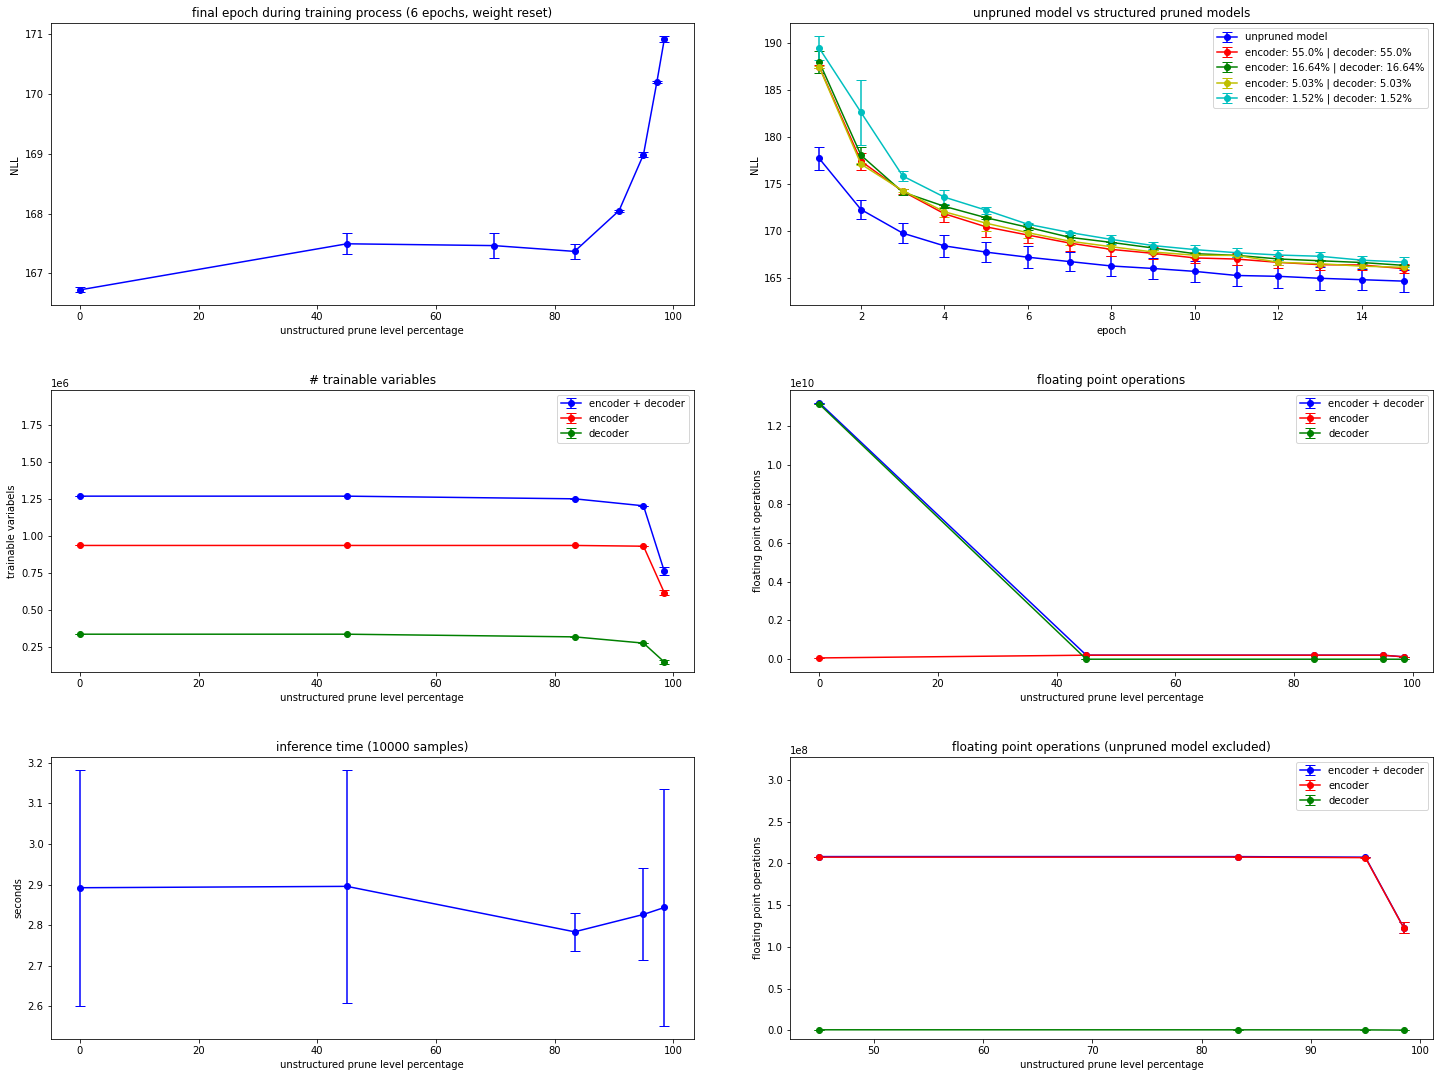

In [ ]:
# EXAMPLES

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=False)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune(create_from_index=1)
lm_pruner.structured_prune(create_from_index=3)
lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=False)
lm_pruner2.unstructured_prune()
lm_pruner2.structured_prune(create_from_index=1)
lm_pruner2.structured_prune(create_from_index=3)
lm_pruner2.structured_prune(create_from_index=5)
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

# function essentially assumes the different pruning instances run identical experiment - purpose: tackle randomness - otherwise just plot manually based on pruner instance variables
lm_pruner.stats.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

# uncertainty based pruner example
#uncertainty_pruner = UncertaintyPruner(CVAE, conf=conf, num_pruning_iterations=25)
#uncertainty_pruner.unstructured_prune()
#uncertainty_pruner.structured_prune()

lol 15 4 1 4 4
[{'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-187.28525, -176.49298, -173.89014, -170.9083, -169.35188, -168.62845, -167.83955, -167.25278, -166.92902, -166.6002, -166.37039, -165.97609, -165.842, -165.82341, -165.44234], 'results_time': [2.8381621837615967, 2.8437283039093018, 2.973695993423462, 2.8032591342926025, 2.7461538314819336, 2.7887496948242188, 2.7616891860961914, 3.0921528339385986, 2.9182825088500977, 2.800567865371704, 2.8209896087646484, 2.78035044670105, 2.8286068439483643, 2.732600688934326, 2.89658522605896]}, {'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-186.83588, -177.1117, -173.76102, -172.45596, -171.45912, -170.029, -169.04701, -168.73764, -167.9602, -167.51628, -167.2401, -166.84824, -166.81827, -166.51976, -166.30045], 'results_time': [2.7750327587127686, 2.7150590419769287, 2.77583646774292, 2.7123355865478516, 2.771244525909424, 2.982

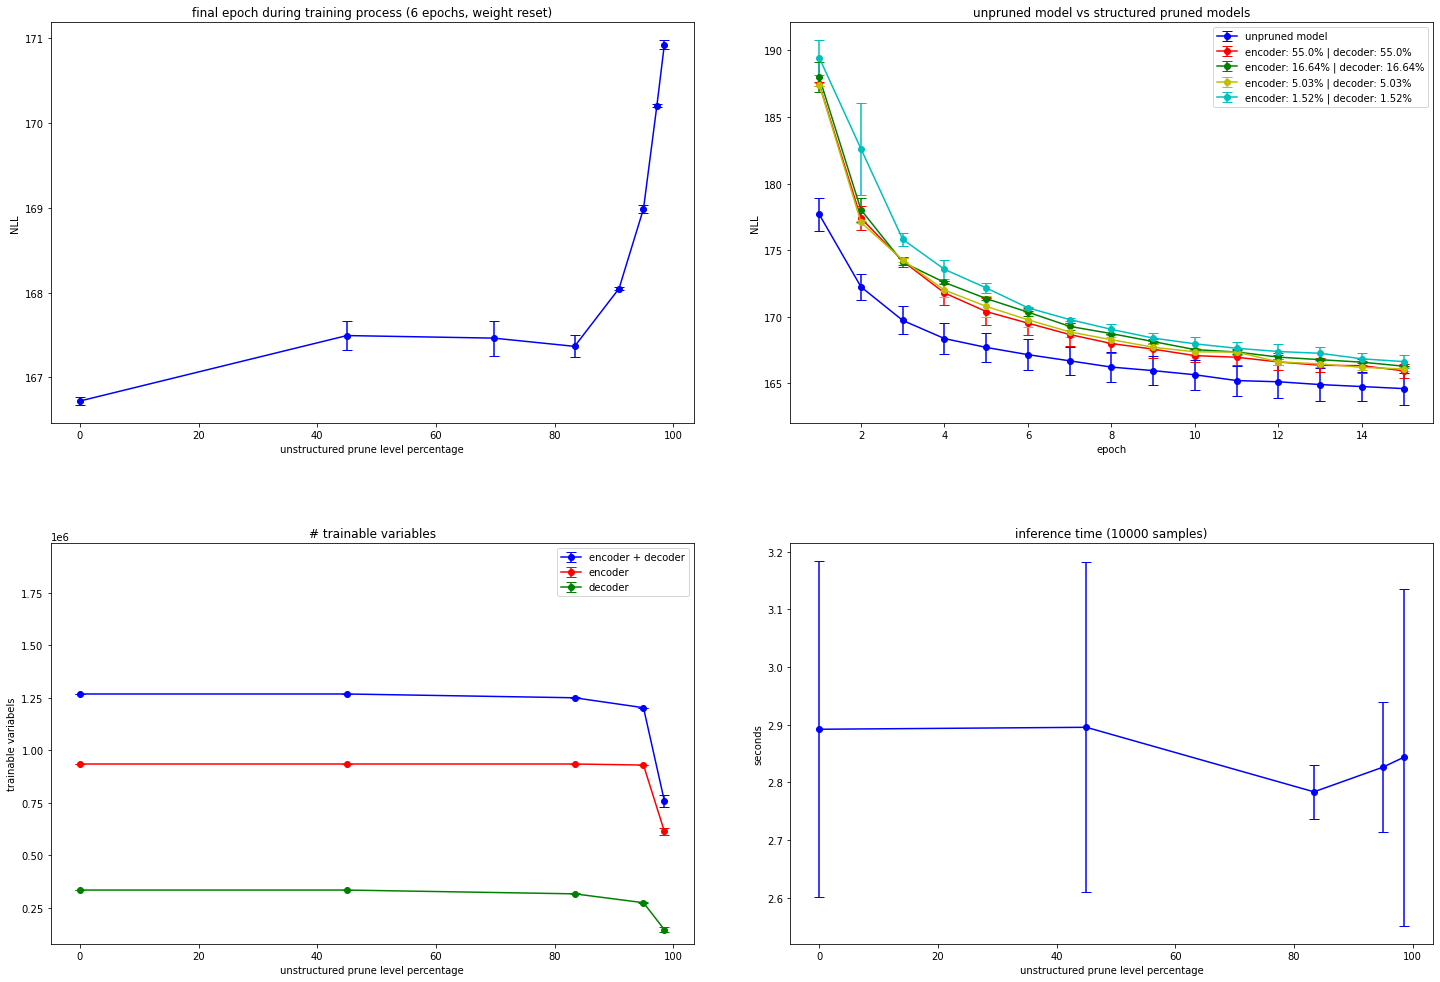

In [ ]:
ps = PruneStats()
ps.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

Epoch: 1, Test set ELBO: -178.5234375, time elapse for current epoch: 23.916261196136475
Epoch: 2, Test set ELBO: -171.1917266845703, time elapse for current epoch: 20.944323778152466
Epoch: 3, Test set ELBO: -169.30113220214844, time elapse for current epoch: 20.906652212142944
Epoch: 4, Test set ELBO: -168.4284210205078, time elapse for current epoch: 20.594260454177856
Epoch: 5, Test set ELBO: -167.5063018798828, time elapse for current epoch: 20.472167491912842
Pruning iteration 1 / 8
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -168.38388061523438, time elapse for current epoch: 46.410473585128784
Epoch: 2, Test set ELBO: -167.475341796875, time elapse for current epoch: 47.052350997924805
Epoch: 3, Test set ELBO: -166.973876953125, time elapse for current epoch: 47.07270932197571
Epoch: 4, Te

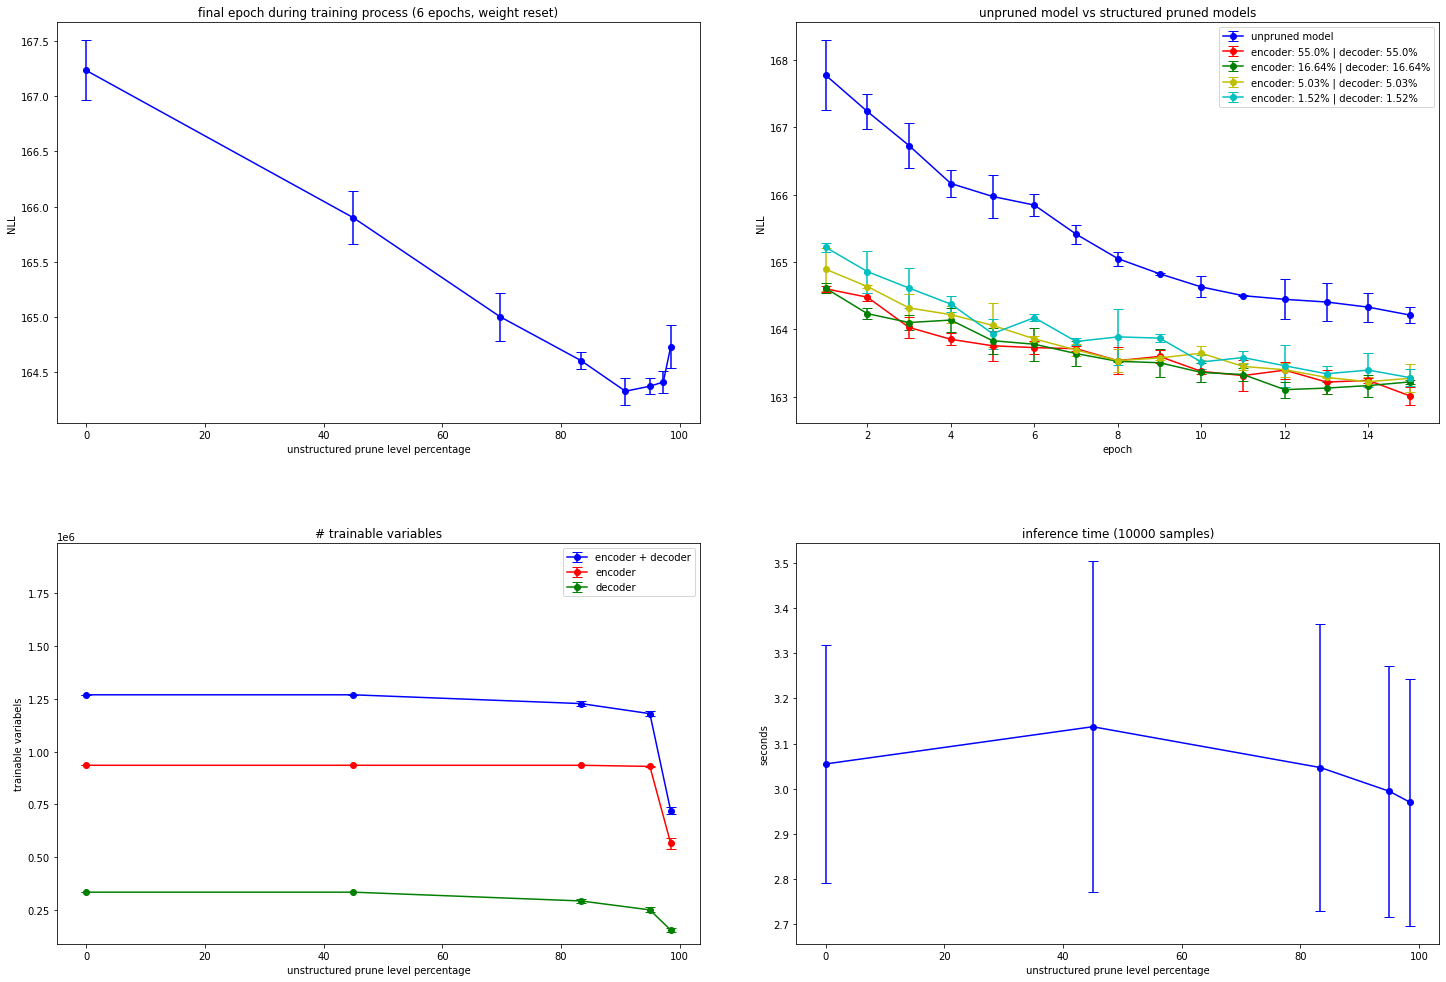

In [ ]:
# EXAMPLES SAME AS ABOVE WITH REWIND TO 3RD EPOCH

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune(create_from_index=1)
lm_pruner.structured_prune(create_from_index=3)
lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner2.unstructured_prune()
lm_pruner2.structured_prune(create_from_index=1)
lm_pruner2.structured_prune(create_from_index=3)
lm_pruner2.structured_prune(create_from_index=5)
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

# function essentially assumes the different pruning instances run identical experiment - purpose: tackle randomness
lm_pruner.stats.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

lol 15 4 1 4 4
[{'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-164.56084, -164.41772, -163.87093, -163.76236, -163.53773, -163.63927, -163.7496, -163.33255, -163.50671, -163.3411, -163.08063, -163.27153, -163.04608, -163.2094, -162.88419], 'results_time': [3.0921545028686523, 3.0052847862243652, 3.0397543907165527, 3.0590579509735107, 3.022315502166748, 3.067185878753662, 3.0225229263305664, 3.0439136028289795, 3.0429322719573975, 2.923332691192627, 2.967848777770996, 2.9307079315185547, 5.1018757820129395, 2.978668689727783, 3.03871750831604]}, {'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-164.53487, -164.1549, -163.9881, -163.96042, -163.64046, -163.53687, -163.4548, -163.52043, -163.29764, -163.21762, -163.23195, -162.98776, -163.04205, -163.00497, -163.18843], 'results_time': [2.918564796447754, 2.8982696533203125, 2.895104169845581, 2.9420928955078125, 2.930347442626953, 2.

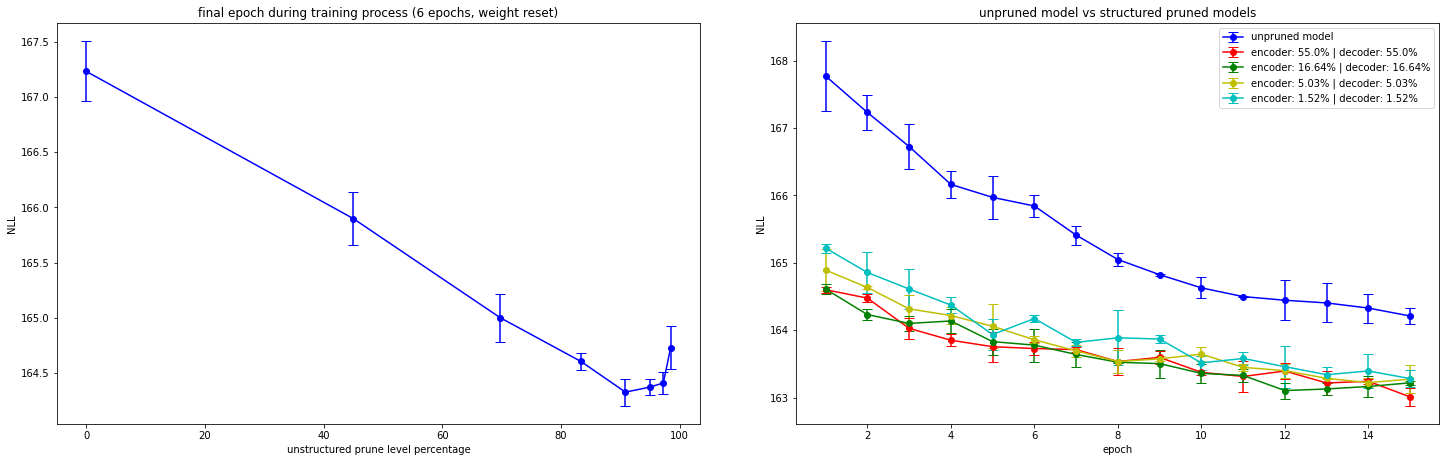

In [ ]:
ps = PruneStats()
ps.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

Epoch: 1, Test set ELBO: -221.02626037597656, time elapse for current epoch: 23.760173320770264
Epoch: 2, Test set ELBO: -210.07073974609375, time elapse for current epoch: 20.519619464874268
Epoch: 3, Test set ELBO: -206.45933532714844, time elapse for current epoch: 20.841286420822144
Epoch: 4, Test set ELBO: -204.01220703125, time elapse for current epoch: 20.685954332351685
Epoch: 5, Test set ELBO: -202.5520477294922, time elapse for current epoch: 20.502657175064087
Pruning iteration 1 / 8
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -221.71485900878906, time elapse for current epoch: 47.1604278087616
Epoch: 2, Test set ELBO: -211.68247985839844, time elapse for current epoch: 48.110026359558105
Epoch: 3, Test set ELBO: -207.0634307861328, time elapse for current epoch: 47.89842867851257
Epoch

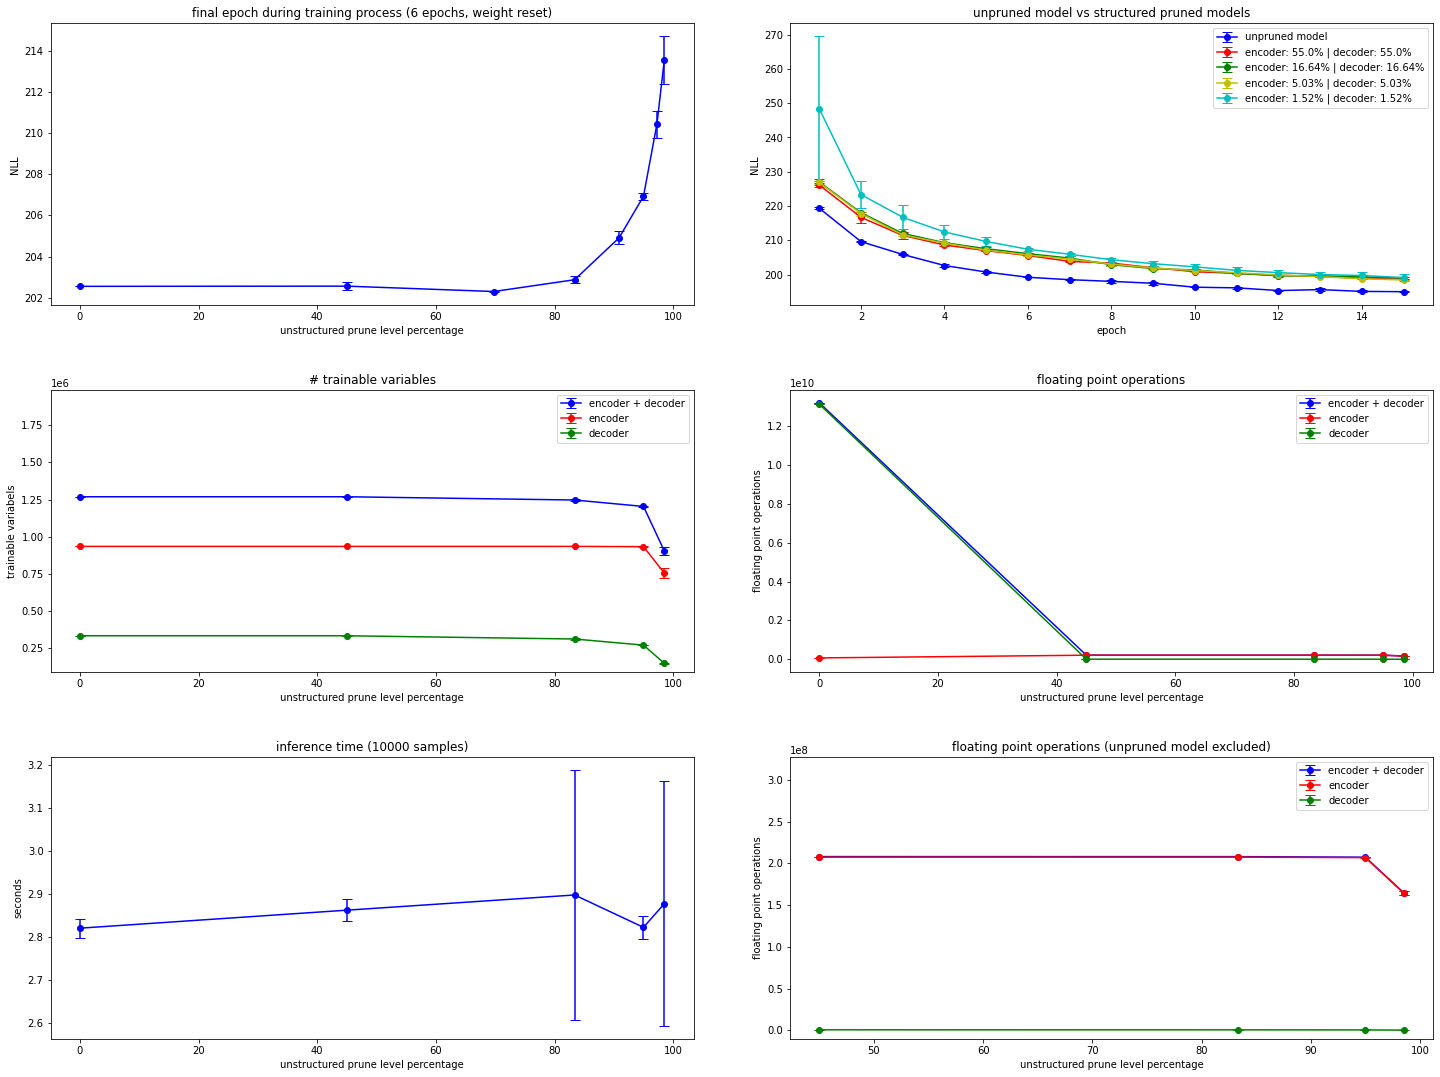

In [ ]:
# EXAMPLES FASHION_MNIST RESET WEIGHTS TO INITIAL

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=False)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune(create_from_index=1)
lm_pruner.structured_prune(create_from_index=3)
lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=False)
lm_pruner2.unstructured_prune()
lm_pruner2.structured_prune(create_from_index=1)
lm_pruner2.structured_prune(create_from_index=3)
lm_pruner2.structured_prune(create_from_index=5)
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

# function essentially assumes the different pruning instances run identical experiment - purpose: tackle randomness
lm_pruner.stats.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

lol 15 4 1 4 4
[{'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-226.83331, -218.23853, -212.55406, -208.94531, -207.11205, -205.4416, -204.01299, -202.88313, -202.03749, -200.78358, -200.36575, -199.88995, -199.55034, -198.93024, -198.8046], 'results_time': [2.897932291030884, 2.814268112182617, 2.926358938217163, 2.8572394847869873, 2.906848669052124, 2.8352510929107666, 2.8500382900238037, 2.8937716484069824, 2.8753209114074707, 2.9009833335876465, 2.886563539505005, 2.824976921081543, 2.7774977684020996, 2.794296979904175, 2.8580691814422607]}, {'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-226.2673, -218.27359, -211.98497, -209.22046, -206.93192, -205.77538, -204.18333, -202.49887, -201.48973, -201.10968, -200.26768, -199.44525, -199.57315, -199.63399, -198.84224], 'results_time': [2.7974016666412354, 2.865400552749634, 2.8094022274017334, 2.792093515396118, 2.9003329277038574

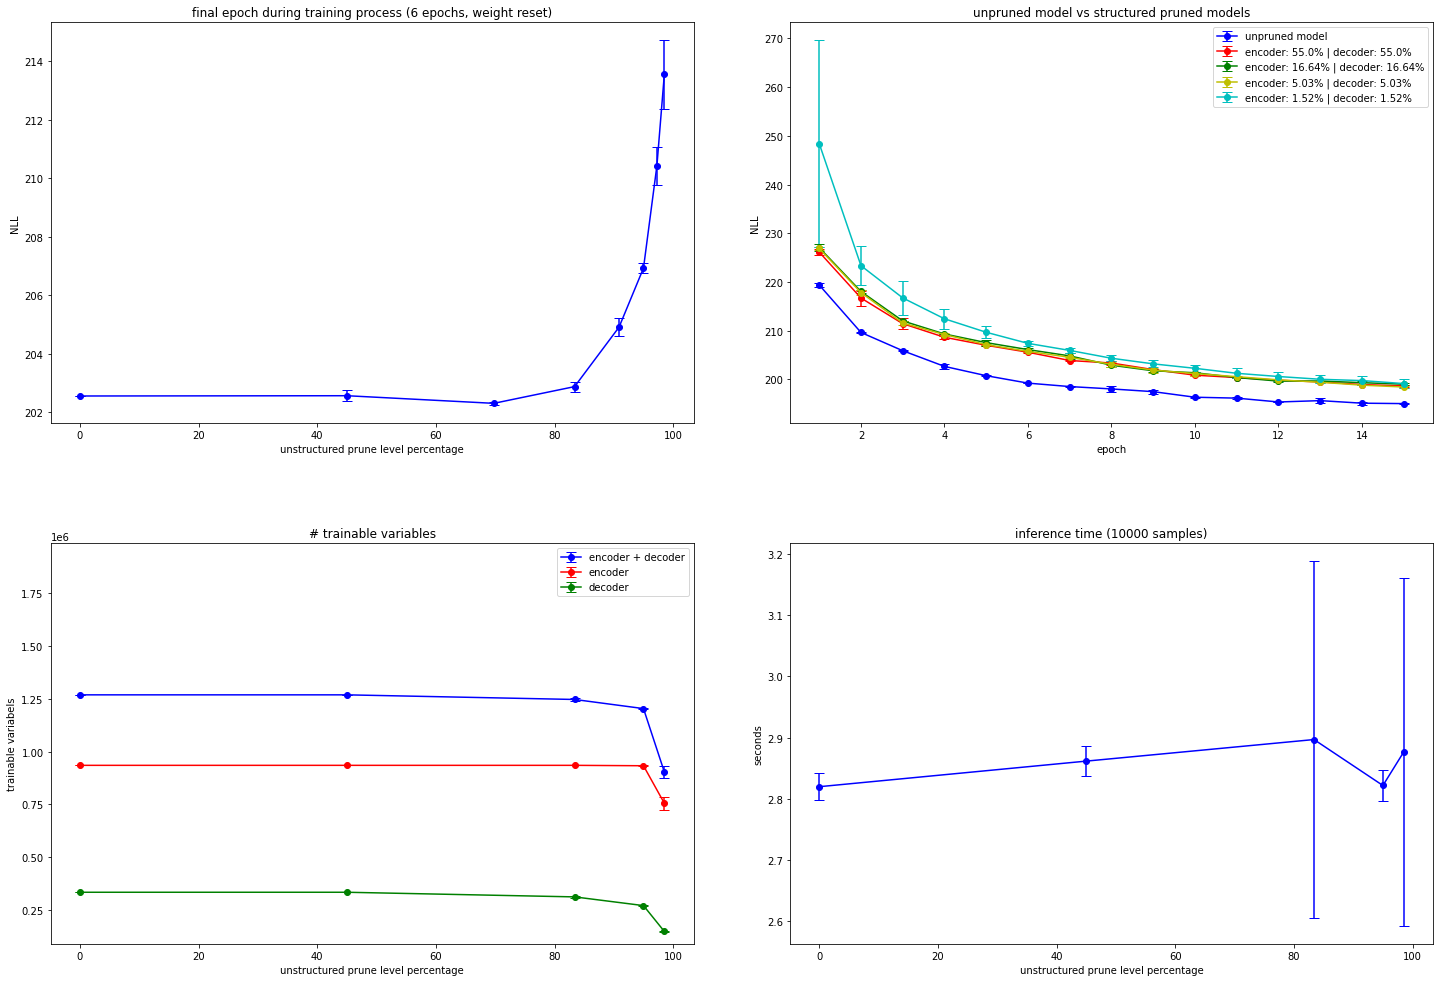

In [ ]:
ps = PruneStats()
ps.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

Epoch: 1, Test set ELBO: -222.1328887939453, time elapse for current epoch: 25.06532311439514
Epoch: 2, Test set ELBO: -211.58700561523438, time elapse for current epoch: 21.479504108428955
Epoch: 3, Test set ELBO: -206.97276306152344, time elapse for current epoch: 21.056638717651367
Epoch: 4, Test set ELBO: -204.3880615234375, time elapse for current epoch: 21.01140069961548
Epoch: 5, Test set ELBO: -202.24160766601562, time elapse for current epoch: 21.11928939819336
Pruning iteration 1 / 8
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -204.1782684326172, time elapse for current epoch: 47.21692609786987
Epoch: 2, Test set ELBO: -202.7350616455078, time elapse for current epoch: 47.6246292591095
Epoch: 3, Test set ELBO: -201.55422973632812, time elapse for current epoch: 47.035767793655396
Epoch: 

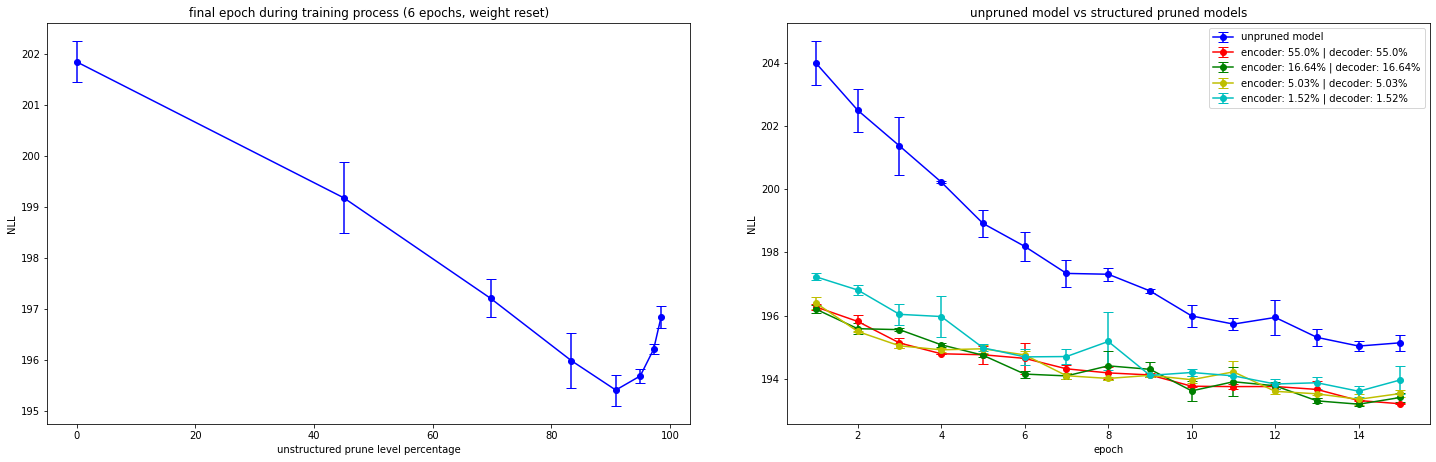

In [ ]:
# EXAMPLES FASHION_MNIST REWIND TO 3rd EPOCH

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune(create_from_index=1)
lm_pruner.structured_prune(create_from_index=3)
lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner2.unstructured_prune()
lm_pruner2.structured_prune(create_from_index=1)
lm_pruner2.structured_prune(create_from_index=3)
lm_pruner2.structured_prune(create_from_index=5)
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

# function essentially assumes the different pruning instances run identical experiment - purpose: tackle randomness
lm_pruner.stats.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

lol 15 4 1 4 4
[{'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-196.35934, -196.00592, -194.98224, -194.79262, -194.47318, -195.12595, -194.18993, -194.00798, -194.17883, -193.77745, -193.82765, -193.84578, -193.93073, -193.29396, -193.19144], 'results_time': [2.84879469871521, 2.806640386581421, 2.8242599964141846, 2.813868284225464, 2.90088152885437, 2.7803256511688232, 2.8034110069274902, 2.7476444244384766, 2.8558545112609863, 2.7891998291015625, 2.770554542541504, 2.7927515506744385, 2.7664072513580322, 2.8109090328216553, 2.786257028579712]}, {'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'x_mul': 15, 'results': [-196.32074, -195.4067, -195.50072, -195.016, -194.69795, -194.25916, -194.1759, -194.87071, -194.52985, -193.29839, -194.36574, -193.8827, -193.21858, -193.15086, -193.25539], 'results_time': [2.7759621143341064, 2.7649025917053223, 2.819441318511963, 2.8011069297790527, 2.8410415649414062, 

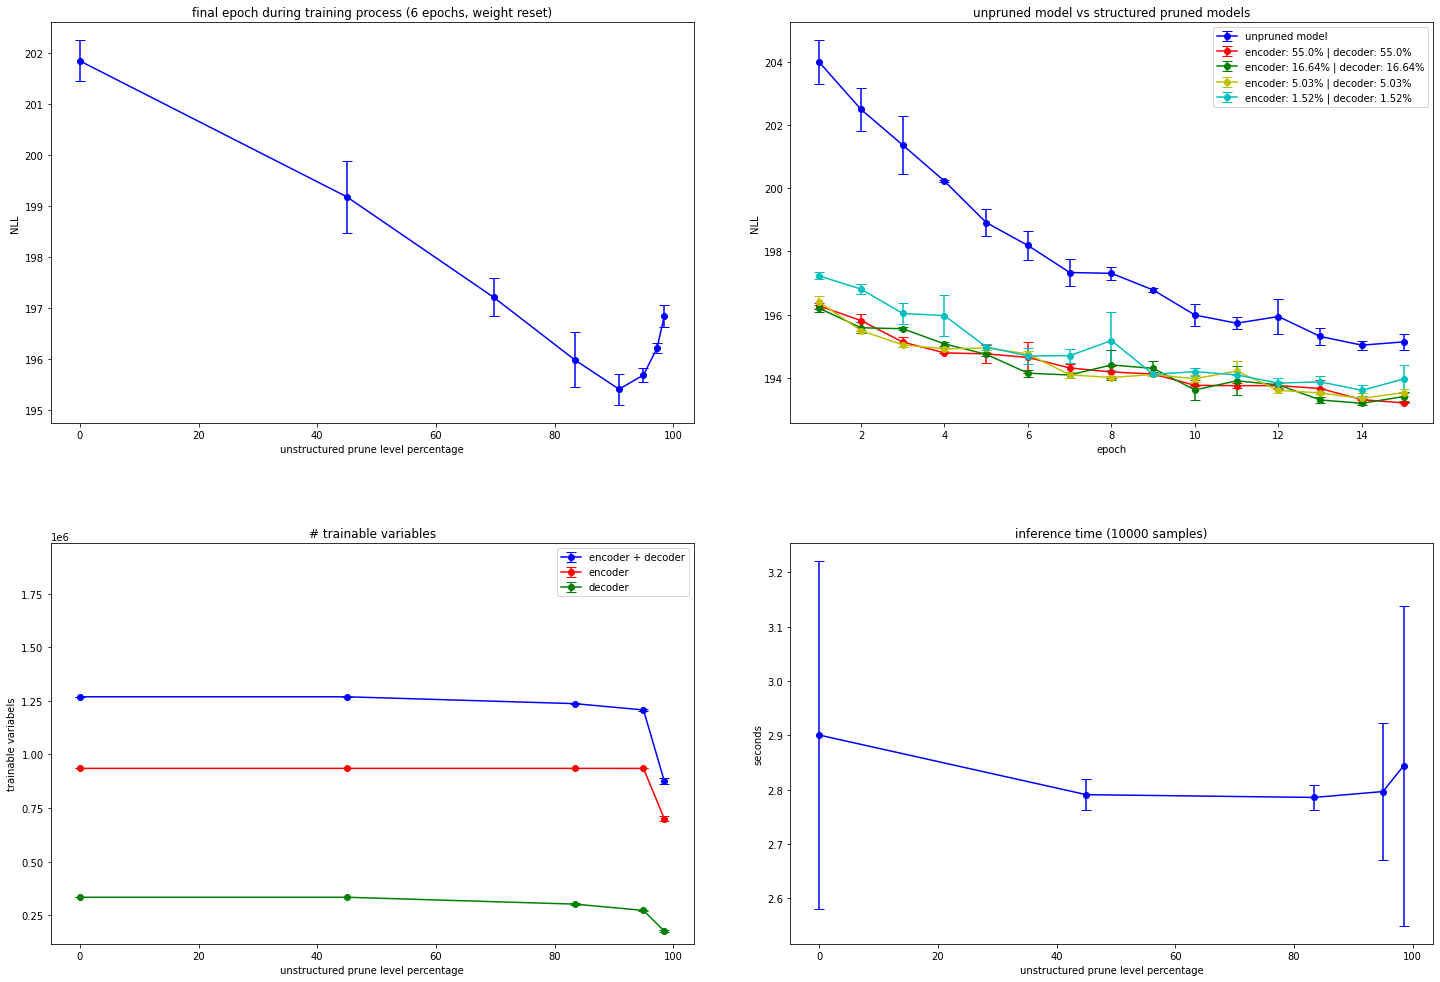

In [ ]:
ps = PruneStats()
ps.combine_and_plot(lm_pruner, [lm_pruner2], lm_pruner.model_pruned_indices)

In [ ]:
# ONE SINGLE RUN FOR RECONSTRUCTION PURPOSES MNIST

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=8, iterative_pruning_percentage=0.45, rewind_weights=False)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune(create_from_index=1)
lm_pruner.structured_prune(create_from_index=3)
lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=15, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=15, model_pruned=False, eval_every_x_epoch=1)

Epoch: 1, Test set ELBO: -178.91441345214844, time elapse for current epoch: 24.760798931121826
Epoch: 2, Test set ELBO: -171.57290649414062, time elapse for current epoch: 20.998696327209473
Epoch: 3, Test set ELBO: -169.215087890625, time elapse for current epoch: 21.272969961166382
Epoch: 4, Test set ELBO: -167.867431640625, time elapse for current epoch: 21.010836601257324
Epoch: 5, Test set ELBO: -167.10824584960938, time elapse for current epoch: 20.73353362083435
Pruning iteration 1 / 8
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -179.63369750976562, time elapse for current epoch: 47.459134578704834
Epoch: 2, Test set ELBO: -171.2681427001953, time elapse for current epoch: 47.24926233291626
Epoch: 3, Test set ELBO: -169.22076416015625, time elapse for current epoch: 46.81552600860596
Epoch

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (32, 28, 28, 1) (28, 28) (28, 28) (32, 2)


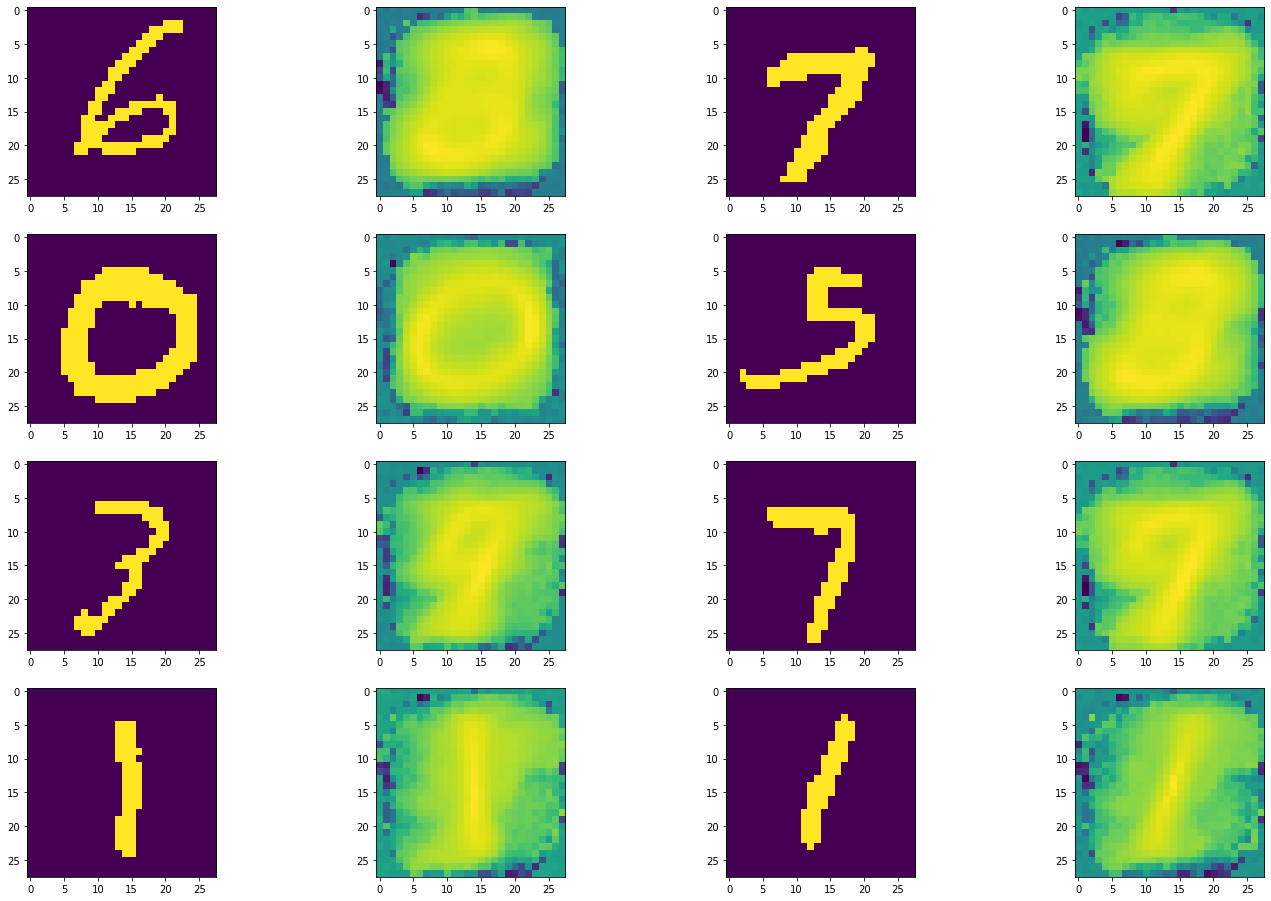

(28, 28, 1) (32, 2) (32, 28, 28, 1)


In [ ]:
for test_x in lm_pruner.test_dataset:
  mean, logvar = lm_pruner.model.encode(test_x)
  z = lm_pruner.model.reparameterize(mean, logvar)
  x_logit = lm_pruner.model.decode(z)
  plt.figure(figsize=(24, 16))
  for i in range(8):
    plt.subplot(4, 4, (i*2+1))
    plt.imshow(tf.squeeze(test_x[i], 2))
    plt.subplot(4, 4, (i*2+2))
    plt.imshow(tf.squeeze(x_logit[i], 2))

  plt.show()
  break


<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (32, 28, 28, 1) (28, 28) (28, 28) (32, 2)


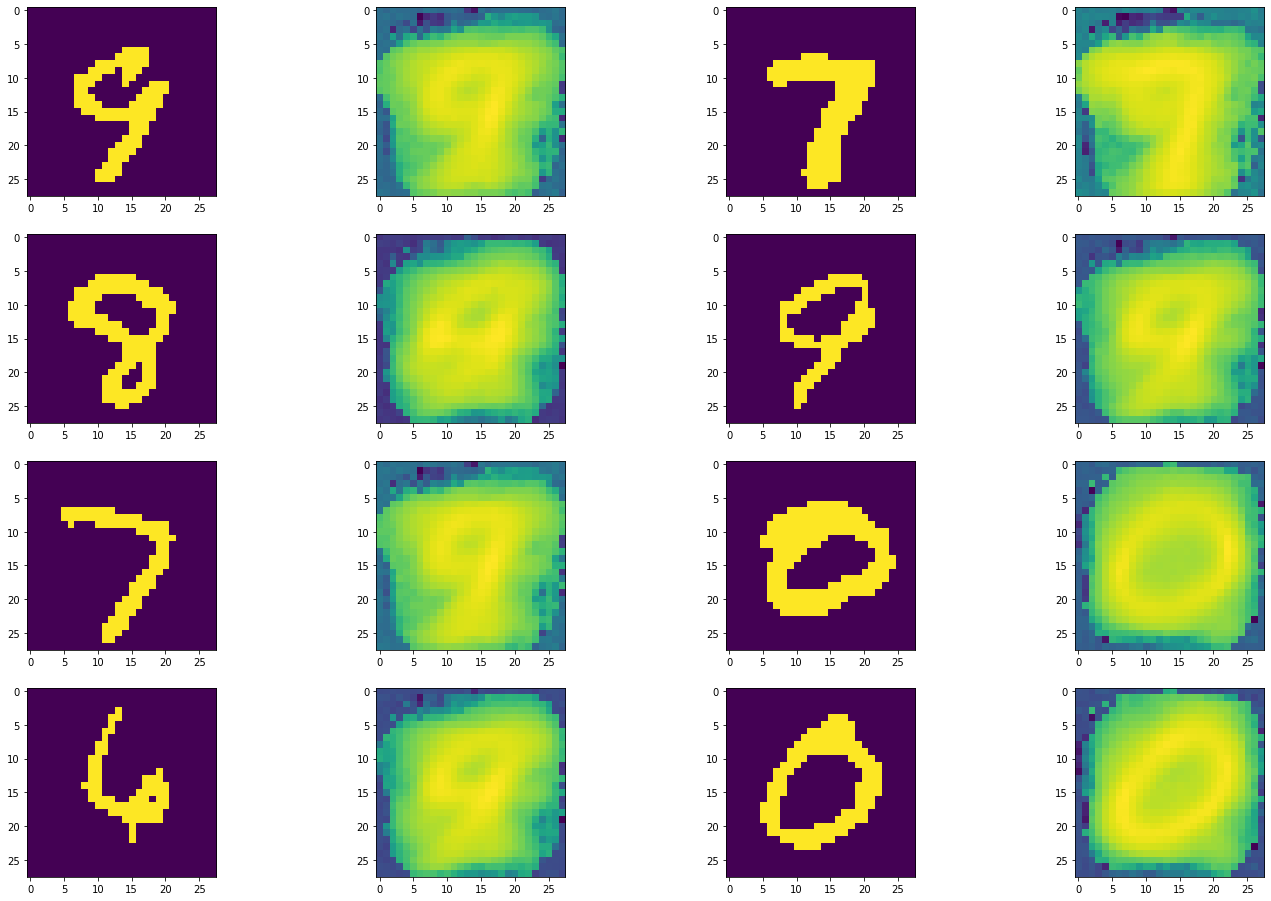

(28, 28, 1) (32, 2) (32, 28, 28, 1)


In [ ]:
for test_x in lm_pruner.test_dataset:
  mean, logvar = lm_pruner.model_pruned[3].encode(test_x)
  z = lm_pruner.model_pruned[3].reparameterize(mean, logvar)
  x_logit = lm_pruner.model_pruned[3].decode(z)
  plt.figure(figsize=(24, 16))
  for i in range(8):
    plt.subplot(4, 4, (i*2+1))
    plt.imshow(tf.squeeze(test_x[i], 2))
    plt.subplot(4, 4, (i*2+2))
    plt.imshow(tf.squeeze(x_logit[i], 2))

  plt.show()
  break

In [ ]:
# ENCODER ONLY

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": False}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=10, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner.unstructured_prune()
#lm_pruner.structured_prune(create_from_index=1)
#lm_pruner.structured_prune(create_from_index=3)
#lm_pruner.structured_prune(create_from_index=5)
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=25, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=25, model_pruned=False, eval_every_x_epoch=1)

Epoch: 1, Test set ELBO: -180.84776306152344, time elapse for current epoch: 22.429818868637085
Epoch: 2, Test set ELBO: -172.1397247314453, time elapse for current epoch: 19.8107647895813
Epoch: 3, Test set ELBO: -169.60377502441406, time elapse for current epoch: 19.88683819770813
Epoch: 4, Test set ELBO: -168.386962890625, time elapse for current epoch: 19.889114379882812
Epoch: 5, Test set ELBO: -167.63633728027344, time elapse for current epoch: 19.94961714744568
Pruning iteration 1 / 10
Encoder | total weights: 131072 non-zero weights: 0 100.0 %.
Decoder | total weights: 131072 non-zero weights: 0 100.0 %.
typpe <class 'numpy.ndarray'> <class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch: 1, Test set ELBO: -168.40359497070312, time elapse for current epoch: 45.30905294418335
Epoch: 2, Test set ELBO: -167.5750274658203, time elapse for current epoch: 45.88212704658508
Epoch: 3, Test set ELBO: -166.92630004882812, time elapse for current epoch: 46.184414863586426
Ep

In [ ]:
# DECODER ONLY

# lowmagnitude conf 
conf={"epochs": 5, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": False, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=10, iterative_pruning_percentage=0.45, rewind_weights=3)
lm_pruner2.unstructured_prune()
#lm_pruner2.structured_prune(create_from_index=1)
#lm_pruner2.structured_prune(create_from_index=3)
#lm_pruner2.structured_prune(create_from_index=5)
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=25, model_pruned=True, eval_every_x_epoch=1)
print()
print()
print()
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=25, model_pruned=False, eval_every_x_epoch=1)

Epoch: 1, Test set ELBO: -179.96337890625, time elapse for current epoch: 21.808021306991577
Epoch: 2, Test set ELBO: -171.59515380859375, time elapse for current epoch: 21.09843683242798
Epoch: 3, Test set ELBO: -169.64828491210938, time elapse for current epoch: 20.714661359786987
Epoch: 4, Test set ELBO: -168.37435913085938, time elapse for current epoch: 20.515305280685425
Epoch: 5, Test set ELBO: -167.36618041992188, time elapse for current epoch: 20.530385494232178
Pruning iteration 1 / 10
Encoder | total weights: 131072 non-zero weights: 0 100.0 %.
Decoder | total weights: 131072 non-zero weights: 0 100.0 %.
Epoch: 1, Test set ELBO: -168.3373260498047, time elapse for current epoch: 47.06022024154663
Epoch: 2, Test set ELBO: -167.5803680419922, time elapse for current epoch: 44.614009857177734
Epoch: 3, Test set ELBO: -166.91319274902344, time elapse for current epoch: 44.63011908531189
Epoch: 4, Test set ELBO: -166.43670654296875, time elapse for current epoch: 45.1818232536315

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (32, 28, 28, 1) (28, 28) (28, 28) (32, 2)


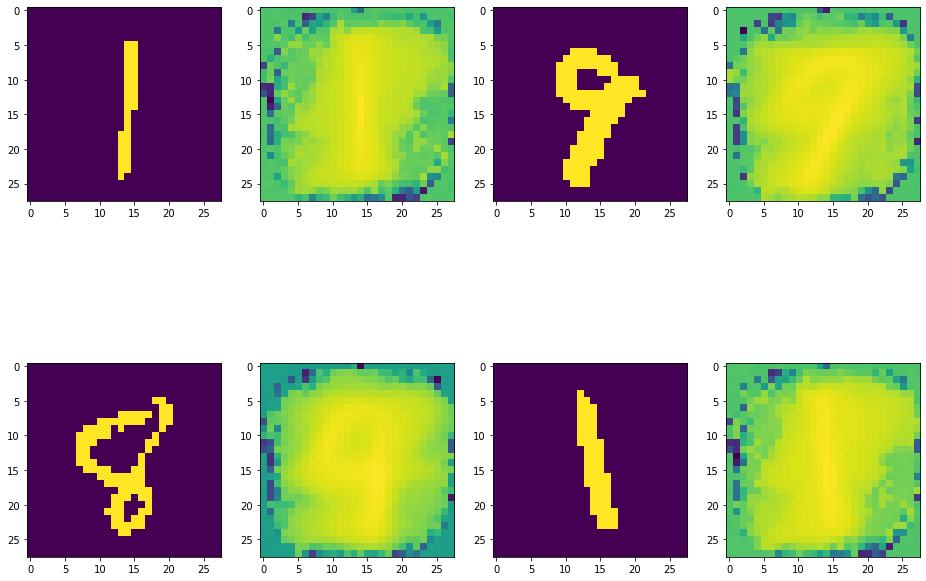

(28, 28, 1) (32, 2) (32, 28, 28, 1)


In [ ]:
# ENCODER ONLY RECONSTRUCTION

for test_x in lm_pruner.test_dataset:
  mean, logvar = lm_pruner.model_pruned[0].encode(test_x)
  z = lm_pruner.model_pruned[0].reparameterize(mean, logvar)
  x_logit = lm_pruner.model_pruned[0].decode(z)
  plt.figure(figsize=(16, 12))
  for i in range(4):
    plt.subplot(2, 4, (i*2+1))
    plt.imshow(tf.squeeze(test_x[i], 2))
    plt.subplot(2, 4, (i*2+2))
    plt.imshow(tf.squeeze(x_logit[i], 2))

  plt.show()
  break

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (32, 28, 28, 1) (28, 28) (28, 28) (32, 2)


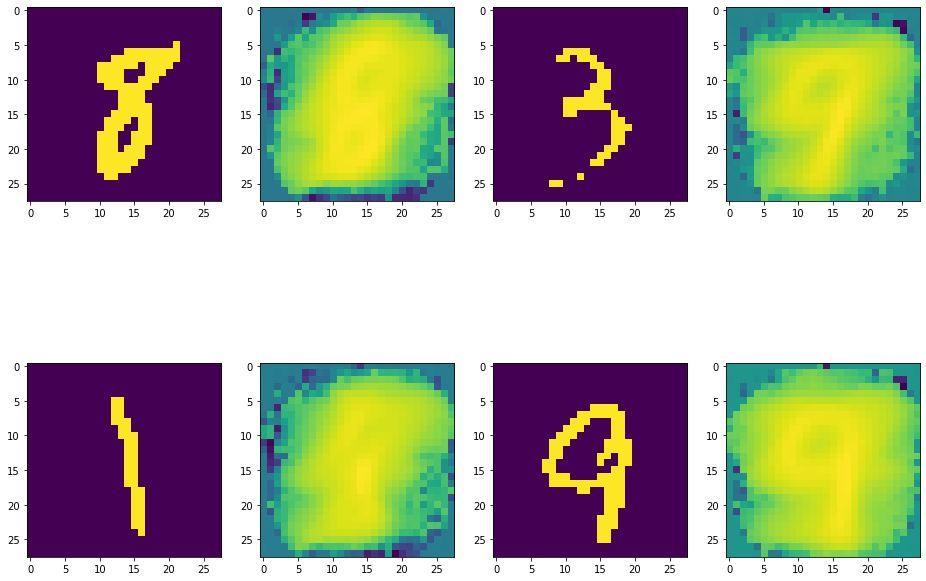

(28, 28, 1) (32, 2) (32, 28, 28, 1)


In [ ]:
# DECODER ONLY RECONSTRUCTIONS

for test_x in lm_pruner2.test_dataset:
  mean, logvar = lm_pruner2.model_pruned[0].encode(test_x)
  z = lm_pruner2.model_pruned[0].reparameterize(mean, logvar)
  x_logit = lm_pruner2.model_pruned[0].decode(z)
  plt.figure(figsize=(16, 12))
  for i in range(4):
    plt.subplot(2, 4, (i*2+1))
    plt.imshow(tf.squeeze(test_x[i], 2))
    plt.subplot(2, 4, (i*2+2))
    plt.imshow(tf.squeeze(x_logit[i], 2))

  plt.show()
  break

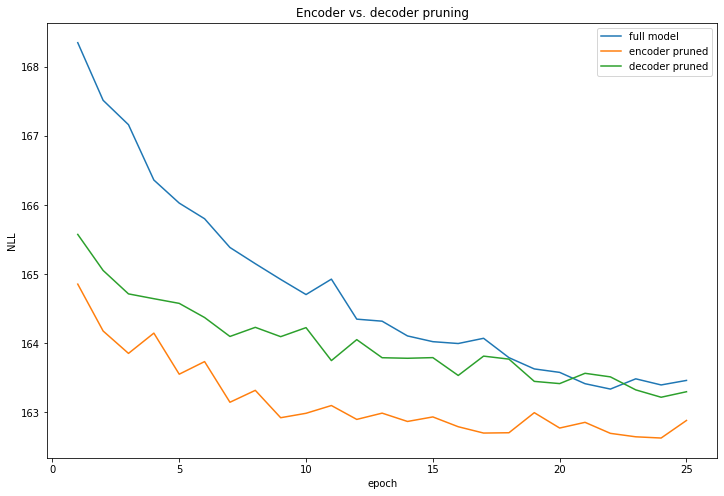

In [ ]:
legend = ["full model", "encoder pruned", "decoder pruned"]
plt.figure(figsize=(12, 8))
x = lm_pruner.model_eval["x"]

y_enc_full = lm_pruner.model_eval["results"]
y_enc_pruned = lm_pruner.model_pruned_eval[0]["results"]
y_dec_full = lm_pruner2.model_eval["results"]
y_dec_pruned = lm_pruner2.model_pruned_eval[0]["results"]
y_enc_full = (np.array(y_enc_full) * -1)
y_enc_pruned = (np.array(y_enc_pruned) * -1).tolist()
y_dec_full = (np.array(y_dec_full) * -1)
y_dec_pruned = (np.array(y_dec_pruned) * -1).tolist()
y_full = np.vstack((y_enc_full, y_dec_full))
y_full = np.mean(y_full, axis=0).tolist()
#plt.plot(x, y_enc_full)
plt.plot(x, y_full)
plt.plot(x, y_enc_pruned)
#plt.plot(x, y_dec_full)
plt.plot(x, y_dec_pruned)
plt.title("Encoder vs. decoder pruning")
plt.xlabel("epoch")
plt.ylabel("NLL")
plt.legend(legend)
plt.show()